In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scalarhadronizer import ScalarHadronizer
from particle import Particle as p
#using the hipsofcobra code to generate pi+pi- and K+K- decay widths, see https://arxiv.org/pdf/2407.13587
#from hipsofcobra import HipsofCobra
import pickle
import os
from iminuit import Minuit
plt.style.use('plotstyle.mplstyle')

# pi and K decay widths from literature

In [2]:
#hips_pi = HipsofCobra( clist=[1,1,1], Pname='pi', method='DGL')
#hips_pi.write_widths()
pi_data=np.loadtxt('hipsofcobra/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_pi_method=DGL.csv',delimiter=',',skiprows=1)
m=pi_data[:,0]
gamma_pi_central=pi_data[:,1][m==2.0][0]
gamma_pi_lower=pi_data[:,2][m==2.0][0]
gamma_pi_upper=pi_data[:,3][m==2.0][0]
pi_width_2GeV=gamma_pi_central
print(pi_width_2GeV)

5.008185005808889e-08


In [3]:
#hips_K = HipsofCobra( clist=[1,1,1], Pname='K', method='DGL')
#hips_K.write_widths()
K_data=np.loadtxt('hipsofcobra/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_K_method=DGL.csv',delimiter=',',skiprows=1)
m=K_data[:,0]
gamma_K_central=K_data[:,1][m==2.0][0]
gamma_K_lower=K_data[:,2][m==2.0][0]
gamma_K_upper=K_data[:,3][m==2.0][0]
K_width_2GeV=gamma_K_central

print(K_width_2GeV)

1.310270241863413e-07


In [4]:
gamma_K_central_last=K_data[-1,1]
gamma_K_lower_last=K_data[-1,2]
gamma_K_upper_last=K_data[-1,3]
gamma_pi_central_last=pi_data[-1,1]
gamma_pi_lower_last=pi_data[-1,2]
gamma_pi_upper_last=pi_data[-1,3]

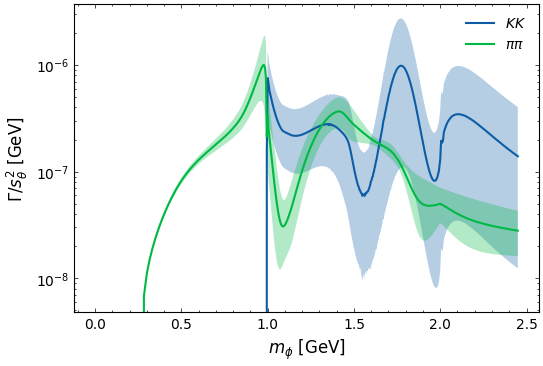

In [176]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(K_data[:,0],K_data[:,1],label=r'$KK$')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\pi\pi$')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.set_yscale('log')
ax.set_xlabel(r'$m_{\phi}$ [GeV]')
ax.set_ylabel(r'$\Gamma/s_\theta^2$ [GeV]')
ax.legend()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/dispersive_result.pdf')

Generated 38 initial meson pairs.
The following initial states were generated:
K*(892)-[-323] K*(892)+[-323]: 0.10575449404597223
K*(892)~0[-313] K*(892)0[-313]: 0.10505698030416057
omega(782)[223] omega(782)[223]: 0.07460485116397067
omega(782)[223] h(1)(1415)[223]: 0.06510225328519126
omega(782)[223] phi(1020)[223]: 0.06293283462152438
omega(782)[223] h(1)(1170)[223]: 0.05333319188866702
rho(770)-[-213] rho(770)+[-213]: 0.04964538315716953
phi(1020)[333] phi(1020)[333]: 0.047119567198943633
K-[-321] K+[-321]: 0.03361036070668834
K~0[-311] K0[-311]: 0.03354955612576682
phi(1020)[333] h(1)(1170)[333]: 0.03166811473720199
omega(782)[223] omega(1420)[223]: 0.029578107824446254
eta[221] f(1)(1420)[221]: 0.02795895845982472
rho(770)0[113] rho(770)0[113]: 0.02481869193700363
eta[221] eta[221]: 0.019894907610377443
eta[221] f(1)(1285)[221]: 0.01949154461579217
eta[221] eta(1475)[221]: 0.017144262851156285
eta[221] eta(2)(1645)[221]: 0.016915379174798538
eta[221] eta'(958)[221]: 0.01683159929

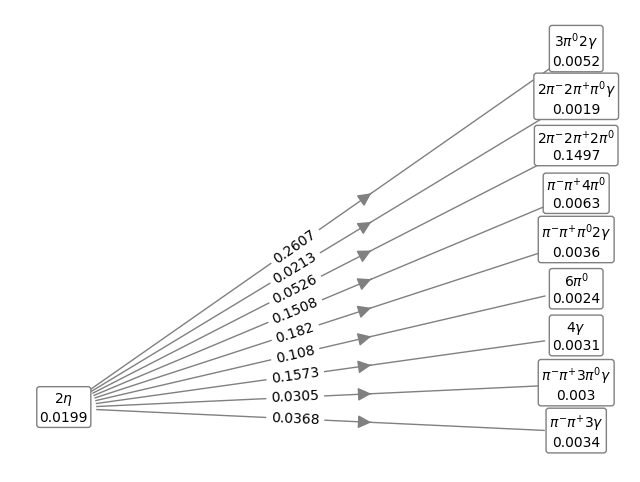

{(310, 310): 1, (-213, 213): 1, (111, 20113): 2, (-211, 111, 111, 211): 0, (9010221, 9010221): 1, (-211, 111, 213): 1, (-213, 111, 211): 1, (-311, 311): 2, (225, 9010221): 1}


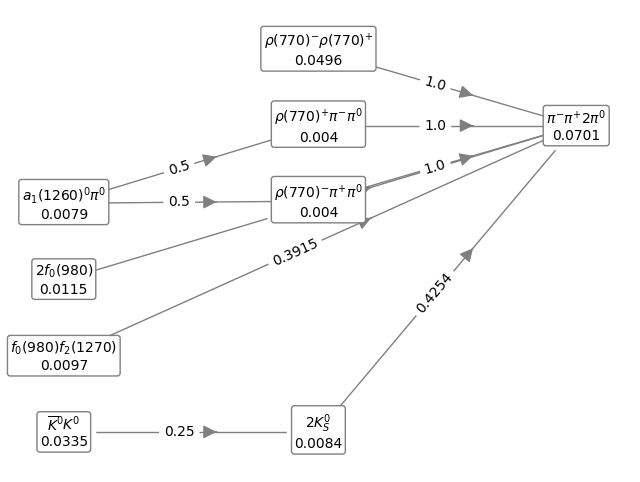

In [36]:
#Plot of a graph for the thesis:
SH=ScalarHadronizer(2300,strange_weight=1,spin_suppression=0.5)
decay_graph=SH.simulateDecay()
SH.print_initial_states()
SH.print_final_states(10,decay_graph)
SH.plot_from_initial_state(decay_graph,(221,221))
SH.plot_from_final_state(decay_graph,(-211,111,111,211),path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/graph.pdf')

# Scalar resonances?

In [94]:
scalar_resonances=p.findall(lambda p: p.J==0 and p.C==1 and p.P==1)# and p.I==0)
for s in scalar_resonances:
    print(s.name,s.mass,s.J)
    dec=SH.single_particle_decays(s.pdgid)
    if (-211,211) in dec:
        print(f'\t pi+pi- br: {dec[(-211,211)]}')
    if (211,-211) in dec:
        print(f'\t pi+pi- br: {dec[(211,-211)]}')

    if (-321,321) in dec:
        print(f'\t K+K- br: {dec[(-321,321)]}')
    if (321,-321) in dec:
        print(f'\t K+K- br: {dec[(321,-321)]}')


a(0)(1450)0 1439.0 0.0
f(0)(1370) 1350.0 0.0
	 pi+pi- br: 0.5200000000000001
	 K+K- br: 0.03500000000000001
f(0)(1710) 1733.0 0.0
chi(c0)(1P) 3414.71 0.0
chi(b0)(1P) 9859.4 0.0
chi(b0)(2P) 10232.5 0.0
a(0)(980)0 980.0 0.0
	 K+K- br: 0.05
f(0)(500) 600.0 0.0
f(0)(980) 990.0 0.0
	 pi+pi- br: 0.6667
f(0)(1500) 1522.0 0.0
	 pi+pi- br: 0.23300000000000004
	 K+K- br: 0.043000000000000003
f(0)(2020) 1982.0 0.0


Since the widths of f(1370) and f(1500) are not very big (from pdg) they shouldnt affect the pi+pi- or K+K- brs too much, so its probably unnecessary to implement resonances in the model. Note: pdg doesn't list the branching ratios above for f(1370)

# Likelihood fit (with fitted pdfs)
(probably not the best way to do it)


In [7]:
def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

print(p_restframe(2000,4,4),p_restframe(2000,2,2))

999.9919999679997 999.997999998


In [1]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


NameError: name 'ScalarHadronizer' is not defined

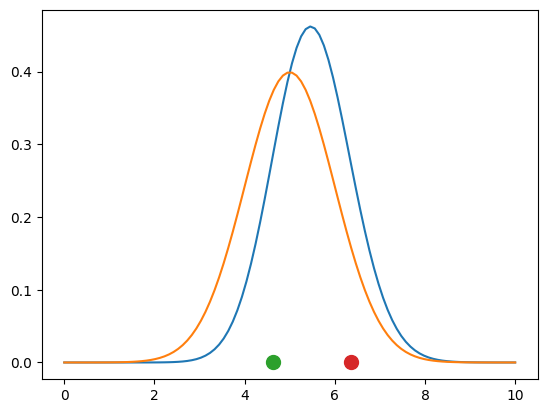

In [8]:
from scipy.stats import skewnorm,norm
x=np.linspace(0,10,100)
xi=5
alpha=0.8
omega=1
plt.plot(x,skewnorm.pdf(x,alpha,loc=xi,scale=omega))
plt.plot(x,norm.pdf(x,loc=xi))
p1=skewnorm.ppf(0.16,alpha,loc=xi,scale=omega)
p2=skewnorm.ppf(0.84,alpha,loc=xi,scale=omega)
plt.plot(p1,0,'o',markersize=10)
plt.plot(p2,0,'o',markersize=10)

In [9]:
def fit_skewnorm(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.16,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.84,median-gamma_pi_central*scaling]

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 9.577e-11 -1.332e-10  4.904e-11]
           x: [ 4.378e+00  1.041e+00  1.332e+00]
        cost: 1.4660893626010036e-20
         jac: [[-3.867e-02  3.975e-02 -2.652e-02]
               [-2.779e-02 -7.157e-02 -1.159e-05]
               [ 1.000e+00  6.053e-01  1.369e-01]]
        grad: [ 4.904e-11  4.303e-11  4.177e-12]
  optimality: 4.903904632747108e-11
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 8
0.2852381953741676
0.17353078237537667


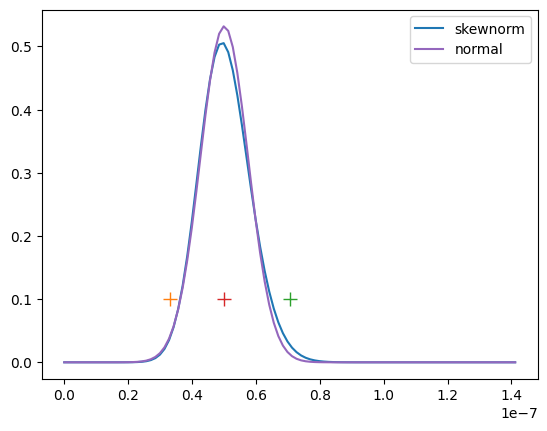

In [10]:
from scipy import optimize
from scipy.stats import skewnorm,norm
def fit_skewnorm_pi(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.01,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_pi_central*scaling]

scaling=1e8
res=optimize.least_squares(fit_skewnorm_pi,x0=(1,1,0),args=(scaling,))
print(res)
x=np.linspace(0,gamma_pi_upper*2,100)
plt.plot(x,skewnorm.pdf(scaling*x,res.x[2],loc=res.x[0],scale=res.x[1]),label='skewnorm')
plt.plot(gamma_pi_lower,0.1,'+',markersize=10)
plt.plot(gamma_pi_upper,0.1,'+',markersize=10)
plt.plot(gamma_pi_central,0.1,'+',markersize=10)

plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_pi_central,scale=(gamma_pi_upper-gamma_pi_lower)/5),label='normal')
plt.legend()
print(abs(1-skewnorm.ppf(0.16,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_lower*1e-8))
print(abs(1-skewnorm.ppf(0.84,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_upper*1e-8))

     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [-9.808e-03  5.588e-03 -1.234e-03]
           x: [ 3.196e+00  4.427e+00]
        cost: 6.446996196525358e-05
         jac: [[-2.485e-04 -5.014e-04]
               [-1.206e-02 -5.306e-03]
               [ 4.099e+00  3.193e+00]]
        grad: [-5.122e-03 -3.964e-03]
  optimality: 0.18063195613521632
 active_mask: [0 0]
        nfev: 200
        njev: 150
2.332039609392891
0.17865059512638826


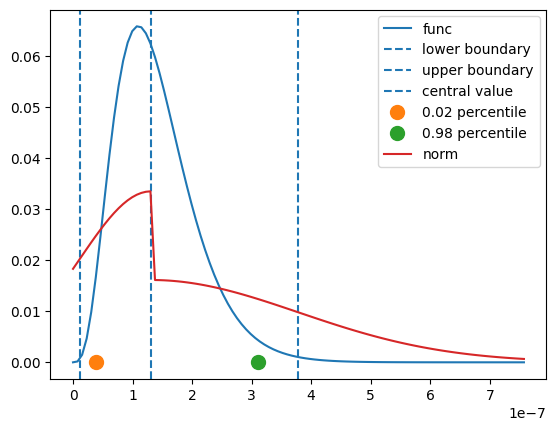

In [11]:
from scipy.stats import gamma,chi
def fit_func_K(x,scaling=1,func=gamma):
    #loc=x[0]
    scale=x[0]
    skew=x[1]
    #loc=x[2]
    loc=0
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_K_lower*scaling,skew,loc=loc,scale=scale)-0.01,func.cdf(gamma_K_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_K_central*scaling]

def fit_gamma_K2(x,scaling=1):
    loc=0
    scale=x[0]
    skew=x[1]
    median=gamma.median(skew,loc=loc,scale=scale)
    mean=func.mean(skew,loc=loc,scale=scale)
    return mean-gamma_K_central*scaling
scaling=1e8
func=gamma
#res_K=optimize.least_squares(fit_func_K,x0=(0,1,1),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,50]))
res_K=optimize.least_squares(fit_func_K,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
#res_K=optimize.least_squares(fit_gamma_K2,x0=(1,1),args=(scaling,),bounds=([1,0],[50,np.inf]))
print(res_K)
if len(res_K.x)<3: loc=0
else: loc=res_K.x[2]
x=np.linspace(0,gamma_K_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_K.x[1],loc=loc,scale=res_K.x[0]),label='func')
plt.axvline(gamma_K_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_K_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_K_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.98 percentile')
#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_K_central,scale=(gamma_K_upper-gamma_K_lower)/4),label='norm')
plt.plot(x,1/scaling*np.where(x<gamma_K_central,norm.pdf(x,loc=gamma_K_central,scale=gamma_K_central-gamma_K_lower),norm.pdf(x,loc=gamma_K_central,scale=gamma_K_upper-gamma_K_central)),label='norm')
plt.legend()
#plt.xscale('log')
print(abs(1-func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_lower*1e-8))
print(abs(1-func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_upper*1e-8))


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.041e-17  0.000e+00 -1.776e-15]
           x: [ 6.317e+00  1.501e+00  7.817e+00]
        cost: 1.5777759772217095e-30
         jac: [[-4.577e-03 -6.197e-02 -4.946e-02]
               [-1.424e-02 -3.482e-02 -2.895e-03]
               [ 1.184e+00  6.236e+00  1.000e+00]]
        grad: [-2.102e-15 -1.108e-14 -1.776e-15]
  optimality: 1.1077078451091316e-14
 active_mask: [0 0 0]
        nfev: 31
        njev: 23
0.6369866978266174
0.4212045467826073


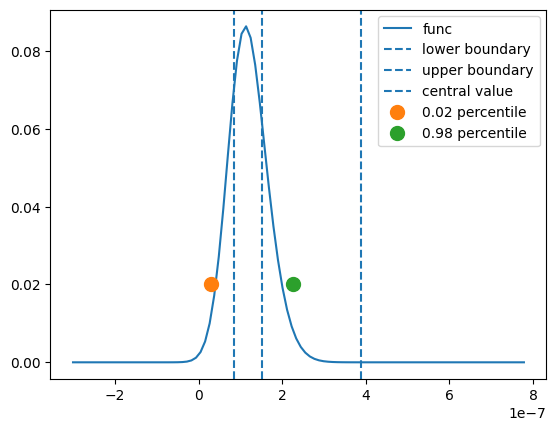

In [12]:
from scipy.stats import gamma,chi2,chi
def fit_func_gamma_tot(x,scaling=1,func=gamma):
    loc=x[2]
    scale=x[0]
    skew=x[1]
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_tot_lower*scaling,skew,loc=loc,scale=scale)-0.02,func.cdf(gamma_tot_upper*scaling,skew,loc=loc,scale=scale)-0.98,median-gamma_tot_central*scaling]

scaling=1e8
func=skewnorm
#res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1,0),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,np.inf]))
print(res_gamma)
if len(res_gamma.x)<3: loc=0
else: loc=res_gamma.x[2]
x=np.linspace(-3e-7,gamma_tot_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_gamma.x[1],loc=loc,scale=res_gamma.x[0]),label='func')
plt.axvline(gamma_tot_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_tot_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_tot_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.98 percentile')


#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_tot_central,scale=(gamma_tot_upper-gamma_tot_lower)/2),label='norm')
plt.legend()
print(abs(1-func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_lower*1e-8))
print(abs(1-func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_upper*1e-8))

In [100]:
def nll(theta,mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot):
    ws=theta[0]
    wv=theta[1]
    gamma_tot=theta[2]
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    gamma_pi=br_pi*gamma_tot
    gamma_K=br_K*gamma_tot
    scaling=1e8
    return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot

mu_pi=gamma_pi_central*scaling
sigma_pi=(gamma_pi_upper-gamma_pi_lower)/5*scaling
a_K=res_K.x[1]
omega_K=res_K.x[0]
a_tot=res_gamma.x[1]
omega_tot=res_gamma.x[0]

nll([1,0.2,gamma_tot_central],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)

np.float64(358.0814395207578)

In [250]:
res_nll=optimize.minimize(nll,(1,0.2,gamma_tot_central*scaling),args=(mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot),bounds=[(0,10),(0,1),(0,gamma_tot_upper*2*scaling)],method='Nelder-Mead')
ws_min=res_nll.x[0]
wv_min=res_nll.x[1]
gamma_tot_min=res_nll.x[2]/scaling
res_nll

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -31.35810968373024
             x: [ 5.310e-01  0.000e+00  1.944e+01]
           nit: 117
          nfev: 204
 final_simplex: (array([[ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01]]), array([-3.136e+01, -3.136e+01, -3.136e+01, -3.136e+01]))

In [194]:
print(res_nll.message)
print(f'L: {res_nll.fun}')
print(f'Parameters:')
print(f'\t ws: {res_nll.x[0]}')
print(f'\t wv: {res_nll.x[1]} ')
print(f'\t gamma_tot: {res_nll.x[2]/scaling}, distance to central value: {1-res_nll.x[2]/scaling/gamma_tot_central}')
print('resulting decay widths:')
br_pi,br_K=pi_K_brs_2GeV(res_nll.x[0],res_nll.x[1])
print(f'br_pi: {br_pi}, gamma_pi: {br_pi*res_nll.x[2]/scaling}, distrance to central value: {1-br_pi*res_nll.x[2]/scaling/gamma_pi_central}')
print(f'br_K: {br_K}, gamma_K: {br_K*res_nll.x[2]/scaling}, distrance to central value: {1-br_K*res_nll.x[2]/scaling/gamma_K_central}')
print(f'')

Optimization terminated successfully.
L: -31.35810968373024
Parameters:
	 ws: 0.5309985875301801
	 wv: 0.0 
	 gamma_tot: 1.9440276023265107e-07, distance to central value: -0.27109620257509026
resulting decay widths:
br_pi: 0.2354134771980641, gamma_pi: 4.5765029763269924e-08, distrance to central value: 0.08619530408345488
br_K: 0.22145190159419254, gamma_K: 4.305086092868045e-08, distrance to central value: 0.6714352539407804



/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


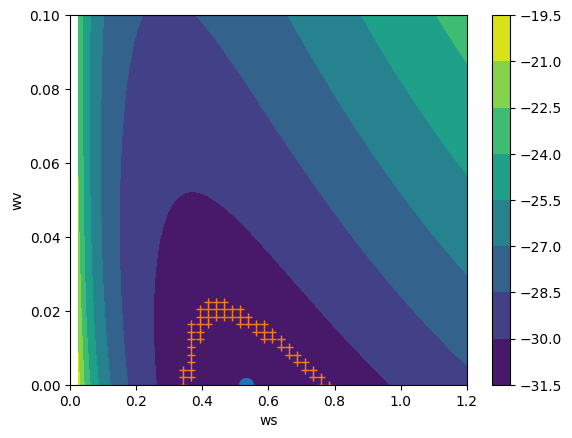

In [170]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper*2,50)
X,Y=np.meshgrid(ws,wv)
nll_const_gamma=np.vectorize(lambda x,y: nll([x,y,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_gamma)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
mask=np.abs(nll_const_gamma-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


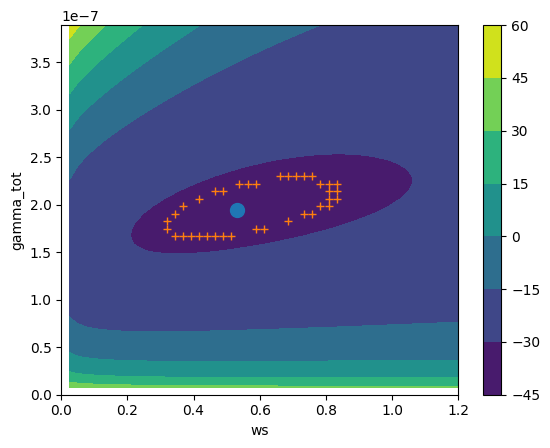

In [197]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper,50)
X,Y=np.meshgrid(ws,gamma_tot)
nll_const_wv=np.vectorize(lambda x,y: nll([x,res_nll.x[1],y*scaling],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma_tot')
plt.plot(res_nll.x[0],res_nll.x[2]/scaling,'o',markersize=10)
mask=np.abs(nll_const_wv-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


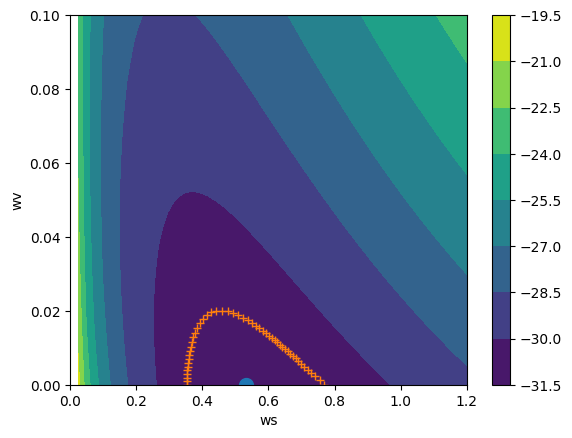

In [ ]:
ws_contour=[]
wv_contour=[]
for phi in np.linspace(0,np.pi,40):
    aspect_ratio=0.1/1.2
    root=optimize.root_scalar(lambda r: nll([r*np.cos(phi)+res_nll.x[0],(r*np.sin(phi)+res_nll.x[1])*aspect_ratio,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,np.sqrt(res_nll.x[0]**2+res_nll.x[1]**2)])
    ws_contour.append(root.root*np.cos(phi)+res_nll.x[0])
    wv_contour.append((root.root*np.sin(phi)+res_nll.x[1])*aspect_ratio)


plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,wv_contour,'+')


-3.141592653589793 0.53099858753018
-3.0133643820146996 0.4031214258456741
-2.885136110439606 0.2773440036206729
-2.7569078388645125 0.15573158265080675
-2.628679567289419 0.04028103552625017
-2.500451295714325 0.5309985875301816
-2.3722230241392315 0.530998587530183
-2.243994752564138 0.5309985875301853
-2.1157664809890444 0.5309985875301885
-1.9875382094139509 0.5309985875301928
-1.8593099378388573 0.5309985875301984
-1.7310816662637636 0.5309985875302053
-1.60285339468867 0.5309985875302136
-1.4746251231135765 0.5309985875302229
-1.3463968515384828 0.5309985875302333
-1.2181685799633892 0.5309985875302445
-1.0899403083882957 0.5309985875302563
-0.9617120368132022 0.5309985875302682
-0.8334837652381086 0.5309985875302797
-0.7052554936630151 0.5309985875302905
-0.5770272220879216 0.5309985875303004
-0.4487989505128276 0.09711484841332516
-0.32057067893773405 0.21589036950689194
-0.19234240736264052 0.339839958829026
-0.06411413578754699 0.4669283675496286
0.06411413578754654 0.5950688

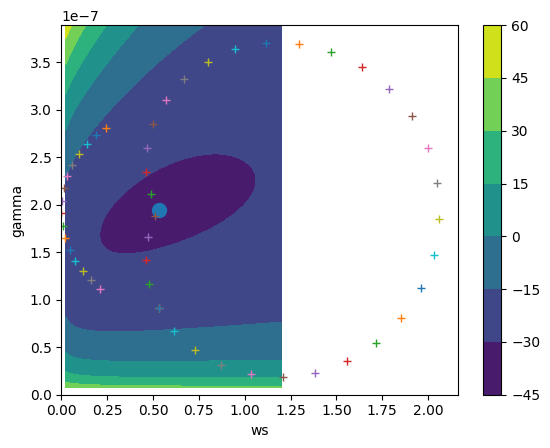

In [281]:
ws_list=[]
wv_list=[]
for phi in np.linspace(0,np.pi,50):
    aspect_ratio=gamma_tot_upper/1.2*scaling
    R=np.sqrt(ws**2+(gamma_tot_min)**2)
    ws=1*np.cos(phi)+ws_min
    gamma=(gamma_tot_upper*np.sin(phi)+gamma_tot_min)
    ws_list.append(ws)
    wv_list.append(gamma)

def get_upper_bound(theta,phi):
    vec=param_vec(1,theta,phi)
    return np.linalg.norm([np.where(vec[0]<0,ws_min,vec[0]),np.where(vec[1]<0,wv_min,vec[1]),np.where(vec[2]<0,gamma_tot_min,vec[2])])

def param_vec(r,theta,phi):
    ws=r*np.sin(theta)*np.cos(phi)+ws_min
    wv=0.1*r*np.sin(theta)*np.sin(phi)+wv_min
    gamma_tot=gamma_tot_min*r*np.cos(theta)+gamma_tot_min
    return np.array([ws,wv,gamma_tot])
theta=np.linspace(-np.pi,np.pi,50)
phi=np.linspace(0,np.pi,50)
theta_grid,phi_grid=np.meshgrid(theta,phi)
upper_bound=upper_bound_vec(theta_grid,phi_grid)
upper_bound=param_vec(1,theta_grid,phi_grid)

plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma')
plt.plot(ws_min,gamma_tot_min,'o',markersize=10)
#plt.plot(ws_list,wv_list,'+')
#plt.plot(upper_bound[0,phi_grid==0],upper_bound[2,phi_grid==0],'+')
for theta in np.linspace(-np.pi,np.pi,50):
    upper_bound=get_upper_bound(theta,0)
    print(theta,upper_bound)
    #upper_bound=1
    plt.plot(param_vec(upper_bound,theta,0)[0],param_vec(upper_bound,theta,0)[2],'+')

print(param_vec(1,-np.pi/2,0))
print(get_upper_bound(-np.pi/2,0))


In [272]:
for theta in np.linspace(-np.pi,np.pi,50):
    for phi in np.linspace(0,np.pi,50):
        upper_bound=get_upper_bound(theta,phi)
        root=optimize.root_scalar(lambda r: nll(param_vec(r,theta,phi),mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,upper_bound])
        

ValueError: f(a) and f(b) must have different signs

In [158]:
from scipy.interpolate import CubicSpline
interpolation = CubicSpline(ws_contour, wv_contour)
plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,interpolation(ws_contour))

ValueError: `x` must be strictly increasing sequence.

In [42]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


# model likelihoods
based on https://arxiv.org/abs/2411.15499v1

In [5]:
from decay_widths import gamma_gg,gamma_ss
m_fit=2450
m_fit_gev=m_fit*1e-3
gamma_had_central=gamma_gg(m_fit_gev)+gamma_ss(m_fit_gev)
gamma_had_err=np.abs(gamma_had_central-gamma_gg(m_fit_gev,mu=2*m_fit_gev)-gamma_ss(m_fit_gev,mu=2*m_fit_gev))
gamma_had_upper=gamma_had_central+gamma_had_err
gamma_had_lower=gamma_had_central-gamma_had_err
print(gamma_had_central,gamma_had_err)

results_dict={'gamma_pi': gamma_pi_central_last,'sigma_pi_upper': gamma_pi_upper_last,'sigma_pi_lower': gamma_pi_lower_last,'gamma_K': gamma_K_central_last,'sigma_K_upper': gamma_K_upper_last,'sigma_K_lower': gamma_K_lower_last,'gamma_had': gamma_had_central,'sigma_had_lower':gamma_had_central-gamma_had_err,'sigma_had_upper':gamma_had_central+gamma_had_err}

6.552215763470703e-07 6.92944119622989e-08


In [6]:
def logL_model(a,central,upper,lower):
    sigp=upper-central
    sigm=central-lower
    sigma1=2*sigp*sigm/(sigp+sigm)
    sigma2=(sigp-sigm)/(sigp+sigm)
    return -0.5*(a-central)**2/(sigma1+(a-central)*sigma2)**2

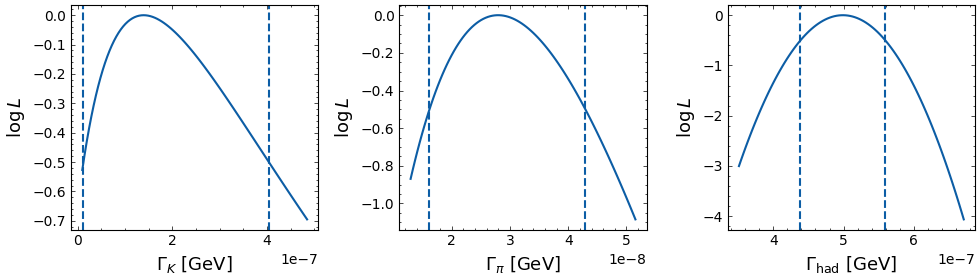

In [175]:
fig,axis=plt.subplots(1,3,figsize=(10,3))
for i,(upper,lower,central,x_label) in enumerate(zip([gamma_K_upper_last,gamma_pi_upper_last,gamma_had_upper],[gamma_K_lower_last,gamma_pi_lower_last,gamma_had_lower],[gamma_K_central_last,gamma_pi_central_last,gamma_had_central],[r'$\Gamma_K$ [GeV]',r'$\Gamma_\pi$ [GeV]',r'$\Gamma_\mathrm{had}$ [GeV]'])):
    x=np.linspace(lower*0.8,upper*1.2,100)
    axis[i].plot(x,logL_model(x,central,upper,lower))
    axis[i].axvline(lower,linestyle='--',label='lower boundary')
    axis[i].axvline(upper,linestyle='--',label='upper boundary')
    axis[i].set_xlabel(x_label,fontsize=13)
    axis[i].set_ylabel(r'$\log L$',fontsize=13)
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/nlls.pdf')

# fit with iminuit

## suppression_mode: spin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.729e-08                  │              Nfcn = 308              │
│ EDM = 1.73e-08 (Goal: 0.0001)    │            time = 4.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │    1.0    │    2.1    │    -1.0    │    2.2     │    0    │   10    │       │
│ 1 │ wv        │   0.09    │   0.23    │   -0.09    │    0.39    │    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.11    │   -0.11    │    0.11    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -1.0    │    2.2    │   -0.09   │   0.39    │   -0.11   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │      5.34     -0.60     0.001 │
│        wv │     -0.60    0.0757     0.002 │
│ gamma_fac │     0.001     0.002    0.0112 │
└───────────┴───────────────────────────────┘

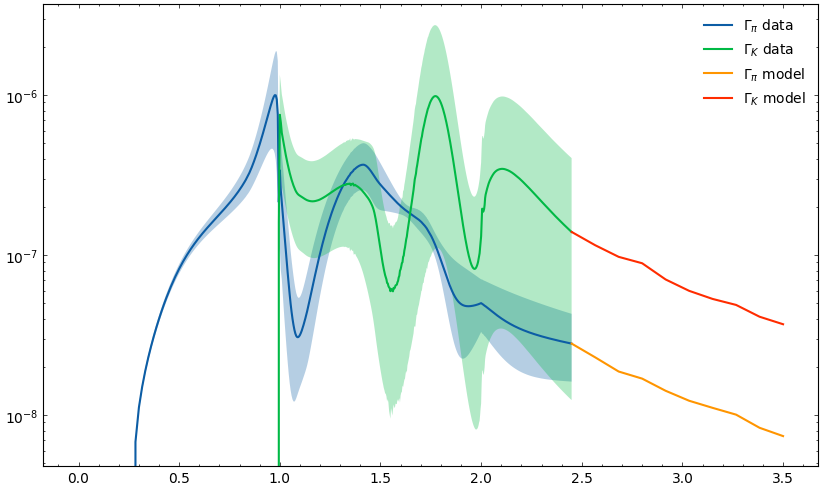

In [7]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='spin')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt=m.params[0].value
wv_opt=m.params[1].value
gamma_fac_opt=m.params[2].value
cov_matrix=np.array(m.covariance)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt,spin_suppression=wv_opt,suppression_mode='spin',gamma_fac=gamma_fac_opt)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt,wv_opt,gamma_fac_opt,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()


In [62]:
ws_upper=m.merrors['ws'].upper
wv_upper=m.merrors['wv'].upper
gamma_fac_upper=m.merrors['gamma_fac'].upper
gamma_fac_lower=abs(m.merrors['gamma_fac'].lower)
likelihood_spin=m.fval

In [60]:
def write_result_to_file(result_dict):
    with open('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/fitdata.dat', 'w') as file:
        for key, value in result_dict.items():
            precision=3
            rounded_val=np.round(value,precision)
            file.write(f"{key},{value}\n")

In [61]:
results_dict['ws']=ws_opt
results_dict['av']=wv_opt
results_dict['a_gamma']=gamma_fac_opt
results_dict['likelihood_spin']=m.fval


results_dict['ws_upper']=ws_upper
results_dict['av_upper']=wv_upper
results_dict['a_gamma_upper']=gamma_fac_upper
results_dict['a_gamma_lower']=gamma_fac_lower
for i in [1,2,3]:
    for j in [1,2,3]:
        name='c'+str(i)+str(j)
        results_dict[name]=cov_matrix[i-1,j-1]

write_result_to_file(results_dict)

### likelihood contours

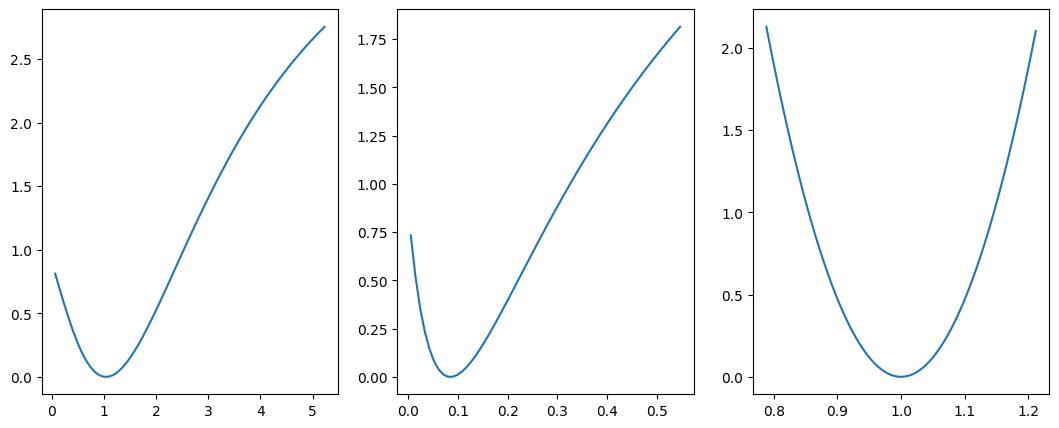

In [28]:
#likelihood profiles
fig,axis=plt.subplots(1,3,figsize=(13,5))
for i,a in enumerate(['ws','wv','gamma_fac']):
    x,y=m.profile(a)
    axis[i].plot(x[x>0],y[x>0])

(array([-8.45169009e-01, -7.39003179e-01, -6.32837350e-01, -5.26671520e-01,
        -4.20505690e-01, -3.14339860e-01, -2.08174031e-01, -1.02008201e-01,
         4.15762891e-03,  1.10323459e-01,  2.16489288e-01,  3.22655118e-01,
         4.28820948e-01,  5.34986778e-01,  6.41152607e-01,  7.47318437e-01,
         8.53484267e-01,  9.59650097e-01,  1.06581593e+00,  1.17198176e+00,
         1.27814759e+00,  1.38431342e+00,  1.49047925e+00,  1.59664508e+00,
         1.70281090e+00,  1.80897673e+00,  1.91514256e+00,  2.02130839e+00,
         2.12747422e+00,  2.23364005e+00,  2.33980588e+00,  2.44597171e+00,
         2.55213754e+00,  2.65830337e+00,  2.76446920e+00,  2.87063503e+00,
         2.97680086e+00,  3.08296669e+00,  3.18913252e+00,  3.29529835e+00,
         3.40146418e+00,  3.50763001e+00,  3.61379584e+00,  3.71996167e+00,
         3.82612750e+00,  3.93229333e+00,  4.03845916e+00,  4.14462499e+00,
         4.25079082e+00,  4.35695665e+00]),
 array([-1.87219825, -1.79577883, -1.7193594

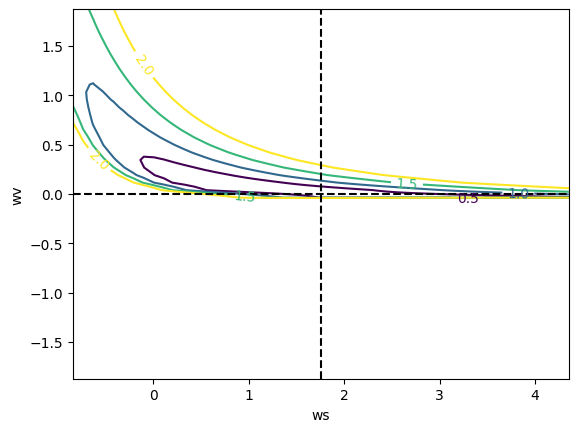

In [48]:
m.draw_contour('ws','wv')

In [87]:
def get_contour(contour_name,par1,par2,cl=0.68,exp=False):
    file_path=f'pkls_for_plots/{contour_name}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            contour = pickle.load(f)
    else:
        if exp: contour=m.mncontour(par1,par2,cl=cl,experimental=True,ncall=5)
        else: contour=m.mncontour(par1,par2,interpolated=400,cl=cl)
        with open(file_path,'wb') as f:
            pickle.dump(contour,f)
    return contour

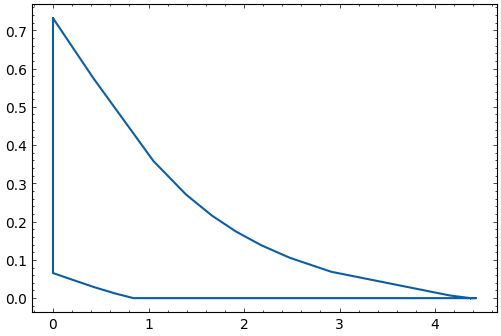

In [29]:
contour_wswv=get_contour('contour_wswv_experimental','ws','wv',exp=True)
plt.plot(contour_wswv[:,0],contour_wswv[:,1])

In [88]:
contour_wvgamma=get_contour('contour_wvgamma','wv','gamma_fac',exp=False)
contour_wvgamma_exp=get_contour('contour_wvgamma_experimental2','wv','gamma_fac',exp=True)

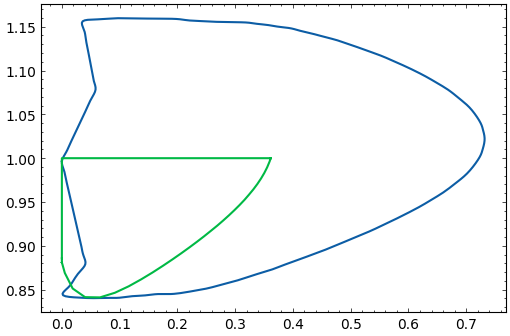

In [89]:
plt.plot(contour_wvgamma[:,0],contour_wvgamma[:,1])
plt.plot(contour_wvgamma_exp[:,0],contour_wvgamma_exp[:,1])
#plt.plot(contour_wvgamma_exp[:,0],2-contour_wvgamma_exp[:,1])

In [86]:
len(gluex)

101

[]

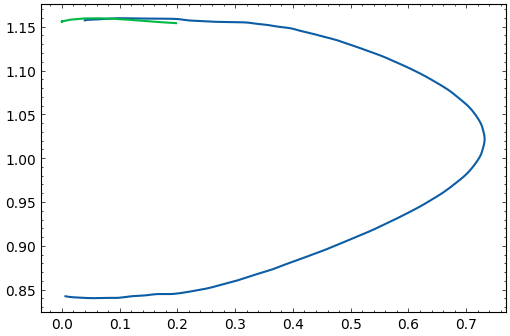

In [85]:
#fix wvgamma contour
cutoff1=65
cutoff2=335
plt.plot(contour_wvgamma[cutoff1:cutoff2,0],contour_wvgamma[cutoff1:cutoff2,1])
cutoff3=8
cutoff4=30
gluex=contour_wvgamma_exp[:,0]
gluey=2-contour_wvgamma_exp[:,1]
plt.plot(gluex[cutoff3:cutoff4],gluey[cutoff3:cutoff4])
plt.plot()

In [ ]:
contour_wswv30=get_contour('contour_wswv30','ws','wv',cl=0.3)

contour_wswv50=get_contour('contour_wswv50','ws','wv',cl=0.5)

In [18]:

contour_wswv10=get_contour('contour_wswv10','ws','wv',cl=0.3)

"\naxis[1].plot(contour_wsgamma[:,0],contour_wsgamma[:,1])\naxis[1].plot(ws_opt,gamma_fac_opt,'+',markersize=10)\naxis[1].set_xlabel(r'$w_s$')\naxis[1].set_ylabel(r'$a_{\\Gamma}$')\n#axis[2].plot(contour_wvgamma_experimental[:,0],contour_wvgamma_experimental[:,1])\naxis[2].plot(np.append(contour_wvgamma[:cutoff,0],contour_wvgamma[-1,0]),np.append(contour_wvgamma[:cutoff,1],contour_wvgamma[-1,1]))\naxis[2].plot(wv_opt,gamma_fac_opt,'+',markersize=10)\naxis[2].set_xlabel(r'$a_v$')\naxis[2].set_ylabel(r'$a_{\\Gamma}$')\naxis[0].legend()\nplt.tight_layout()\nplt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/likelihood_contours.pdf')\n"

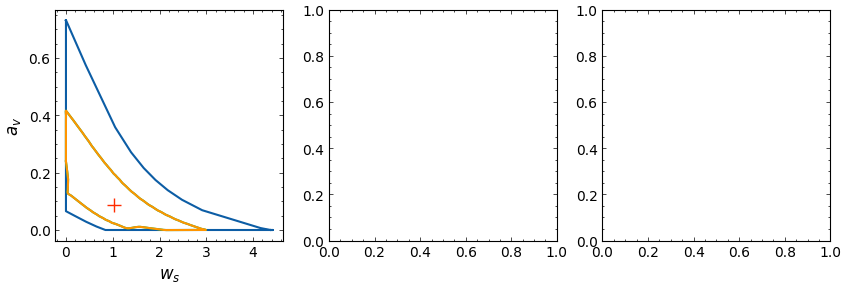

In [92]:
fig,axis=plt.subplots(1,3,figsize=(10,3))
axis[0].plot(contour_wswv[:,0],contour_wswv[:,1],label='68%')
axis[0].plot(contour_wswv10[:,0],contour_wswv10[:,1],label='30%')
axis[0].plot(contour_wswv30[:,0],contour_wswv30[:,1],label='30%')
#axis[0].plot(contour_wswv50[:,0],contour_wswv50[:,1])
axis[0].plot(ws_opt,wv_opt,'+',markersize=10,label='best fit')
axis[0].set_xlabel(r'$w_s$')
axis[0].set_ylabel(r'$a_v$')

"""
axis[1].plot(contour_wsgamma[:,0],contour_wsgamma[:,1])
axis[1].plot(ws_opt,gamma_fac_opt,'+',markersize=10)
axis[1].set_xlabel(r'$w_s$')
axis[1].set_ylabel(r'$a_{\Gamma}$')
#axis[2].plot(contour_wvgamma_experimental[:,0],contour_wvgamma_experimental[:,1])
axis[2].plot(np.append(contour_wvgamma[:cutoff,0],contour_wvgamma[-1,0]),np.append(contour_wvgamma[:cutoff,1],contour_wvgamma[-1,1]))
axis[2].plot(wv_opt,gamma_fac_opt,'+',markersize=10)
axis[2].set_xlabel(r'$a_v$')
axis[2].set_ylabel(r'$a_{\Gamma}$')
axis[0].legend()
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/likelihood_contours.pdf')
"""

### result of best fit model

In [19]:
print(m_fit,ws_opt,wv_opt,gamma_fac_opt)
SH_best_fit=ScalarHadronizer(scalar_mass=m_fit,strange_weight=ws_opt,spin_suppression=wv_opt,gamma_fac=gamma_fac_opt)
SH_best_fit.simulateDecay()

2450 1.0215839592483356 0.08655356535516996 0.99998624832845
Generated 47 initial meson pairs.


In [21]:
SH_best_fit.print_final_states(10)

The following final states were generated:
(-321, 321) K- K+ :  0.10661372892347296
(-211, -211, 111, 111, 211, 211) pi- pi- pi0 pi0 pi+ pi+ :  0.0791129695831305
(-211, 111, 111, 211) pi- pi0 pi0 pi+ :  0.06644249008853151
(-211, -211, 211, 211) pi- pi- pi+ pi+ :  0.051110962300185636
(-211, 130, 211) pi- K(L)0 pi+ :  0.036890439288395756
(-211, 211) pi- pi+ :  0.03418595873157222
(-321, -211, 211, 321) K- pi- pi+ K+ :  0.028766345992679708
(130, 130) K(L)0 K(L)0 :  0.026612052171380466
(-321, -211, 111, 211, 321) K- pi- pi0 pi+ K+ :  0.01881624750019057
(111, 111, 130) pi0 pi0 K(L)0 :  0.016333665054365187


Generated 139 initial meson pairs.


(<Figure size 400x500 with 1 Axes>, <Axes: xlabel='branching ratio'>)

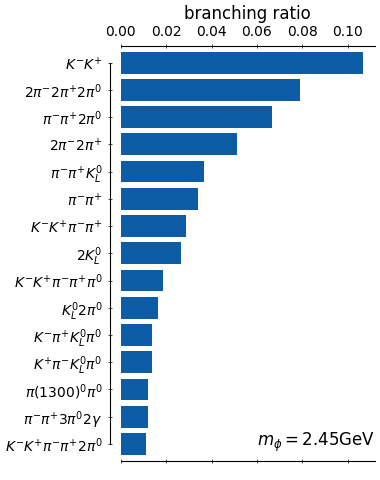

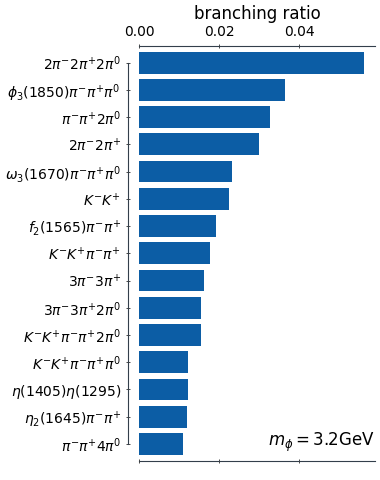

In [10]:
SH_best_fit.plot_final_state_hist(show=False,n=15,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist1.pdf')
SH_best_fit2=ScalarHadronizer(scalar_mass=3200,strange_weight=ws_opt,spin_suppression=wv_opt,gamma_fac=gamma_fac_opt)
SH_best_fit2.simulateDecay()
SH_best_fit2.plot_final_state_hist(show=False,n=15,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist2.pdf')


(<Figure size 400x500 with 1 Axes>, <Axes: xlabel='branching ratio'>)

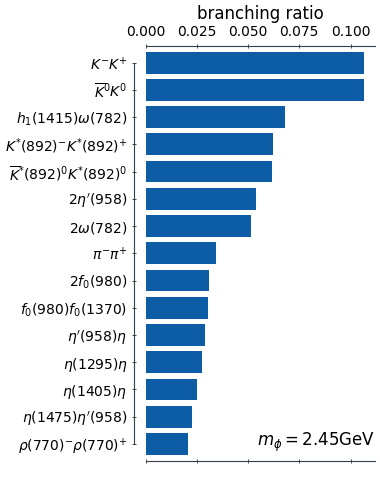

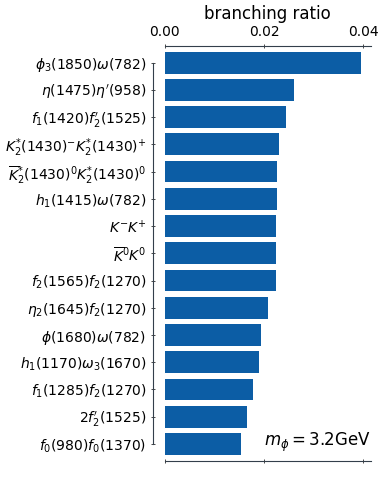

In [11]:
SH_best_fit.plot_initial_state_hist(n=15,show=False,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/initial_state_hist1.pdf')
SH_best_fit2.plot_initial_state_hist(n=15,show=False,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/initial_state_hist2.pdf')

In [69]:
p.findall('omega')

[<Particle: name="omega(782)", pdgid=223, mass=782.66 ± 0.13 MeV>,
 <Particle: name="omega(3)(1670)", pdgid=227, mass=1667 ± 4 MeV>,
 <Particle: name="omega(1650)", pdgid=30223, mass=1670 ± 30 MeV>,
 <Particle: name="omega(1420)", pdgid=100223, mass=1410 ± 60 MeV>]

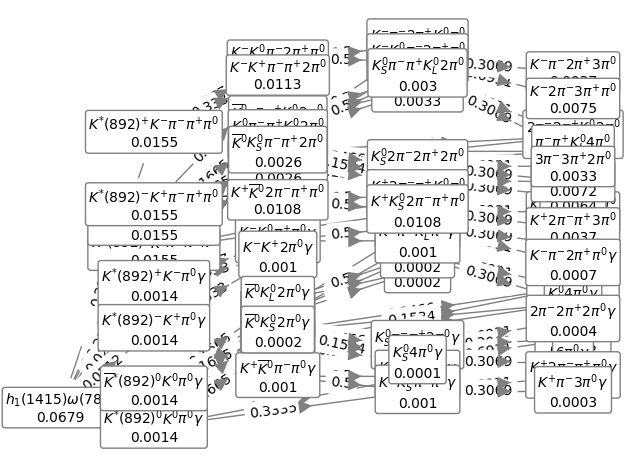

In [70]:
SH_best_fit.plot_from_initial_state((223,10333))

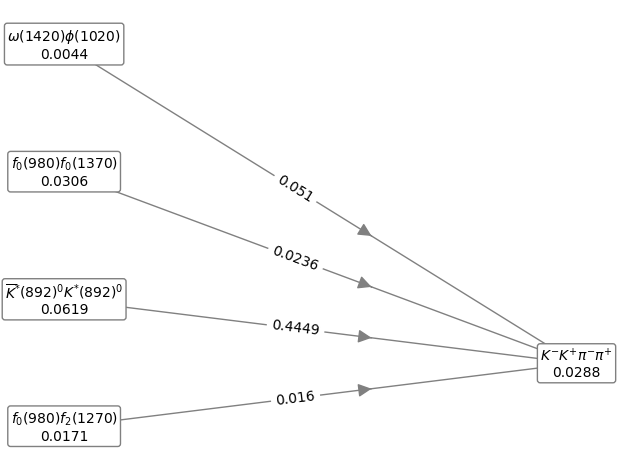

In [44]:
SH_best_fit.plot_from_final_state((-321,-211,211,321))

KeyError: (310, 310)

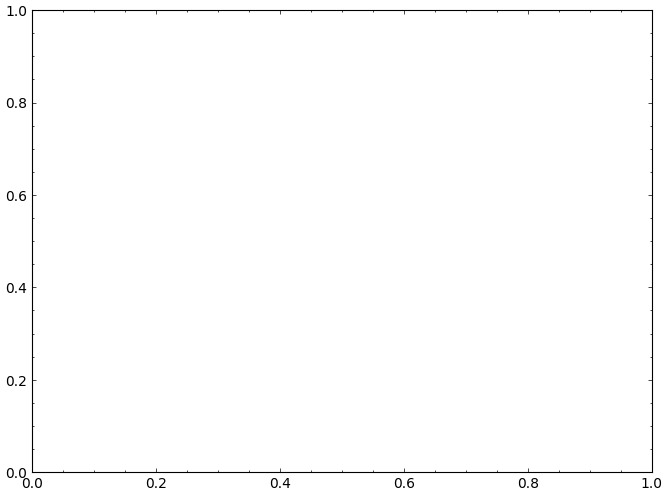

In [160]:
SH_best_fit.plot_from_final_state((-211,111,111,211))
#SH_best_fit2.plot_from_final_state((-211,111,111,211))

### error from monte carlo method

In [30]:
import networkx as nx

def sample_positive_multivariate_normal(mean, cov, size=1):
    samples = []
    while len(samples) < size:
        sample = np.random.multivariate_normal(mean, cov)
        if np.all(sample > 0):
            samples.append(sample)
    return np.array(samples)

def compute_errors(m,ws_opt,wv_opt,gamma_fac_opt,cov_matrix):
    sampled_pars = sample_positive_multivariate_normal([ws_opt, wv_opt, gamma_fac_opt], cov_matrix, 100)
    SH_sampled = ScalarHadronizer(scalar_mass=m)
    decay_graph_init, _ = SH_sampled.build_decay_graph(exclude_below_threshold=False)
    fs_keys = [s for s, d in decay_graph_init.out_degree() if d == 0]
    
    final_state_samples = {key: [[], []] for key in fs_keys}
    final_state_samples.update({'total': [], 'pi': [[], []], 'K': [[], []]})
    
    for ws_sample, wv_sample, gamma_sample in sampled_pars:
        SH_sampled.set_parameters(spin_suppression=wv_sample,strange_weight= ws_sample, gamma_fac=gamma_sample)
        new_initial_states = SH_sampled.make_initialMesonPairs(exclude_below_threshold=False)
        reweighted_graph = SH_sampled.buildWeights(decay_graph_init, new_initial_states, fs_keys)
        attributes = nx.get_node_attributes(reweighted_graph, 'weight')
        gam_tot = SH_sampled.get_decay_width(1) 
        
        for key in fs_keys:
            final_state_samples[key][0].append(attributes[key])
            final_state_samples[key][1].append(SH_sampled.get_decay_width(attributes[key]))
        
        final_state_samples['total'].append(gam_tot)
        final_state_samples['pi'][0].append(attributes[(-211, 211)] + attributes[(111, 111)])
        final_state_samples['pi'][1].append(SH_sampled.get_decay_width(attributes[(-211, 211)] + attributes[(111, 111)]))
        final_state_samples['K'][0].append(attributes[(-321, 321)] + attributes[(-311, 311)])
        final_state_samples['K'][1].append(SH_sampled.get_decay_width(attributes[(-321, 321)] + attributes[(-311, 311)]))
    
    fs_mean_std = {s: {'BR mean': np.mean(v[0]), 'BR std': np.std(v[0]), 'gamma mean': np.mean(v[1]), 'gamma std': np.std(v[1])} for s, v in final_state_samples.items()}
    
    SH_sampled.set_parameters(spin_suppression=wv_opt,strange_weight=ws_opt,gamma_fac=gamma_fac_opt)
    new_initial_states = SH_sampled.make_initialMesonPairs(exclude_below_threshold=False)
    reweighted_graph = SH_sampled.buildWeights(decay_graph_init, new_initial_states, fs_keys)
    attributes = nx.get_node_attributes(reweighted_graph, 'weight')
    
    for key in fs_keys:
        fs_mean_std[key]['BR central'] = attributes[key]
    
    fs_mean_std['pi']['BR central'] = attributes[(-211, 211)] + attributes[(111, 111)]
    fs_mean_std['K']['BR central'] = attributes[(-321, 321)] + attributes[(-311, 311)]
    
    return fs_mean_std, decay_graph_init

In [45]:
#test bias
SH=ScalarHadronizer(2000,strange_weight=ws_opt,spin_suppression=wv_opt,supression_mode='spin',gamma_fac=gamma_fac_opt)
decay_graph=SH.simulateDecay()
final_states=SH.get_final_states(decay_graph)
fs_mean_and_errors,_=compute_errors(2000)
err=np.zeros(len(final_states))
for i,key in enumerate(final_states):
    err[i]=1-fs_mean_and_errors[key]['BR mean']/final_states[key]
print(np.mean(err),np.std(err))

Generated 14 initial meson pairs.
Generated 26 initial meson pairs.
-0.1597547444707317 0.49846413735237743


In [61]:
import pickle
import os

m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_montecarlo.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors,dg=compute_errors(mass,ws_opt,wv_opt,gamma_fac_opt,cov_matrix)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

In [ ]:
#test bias
#err=[v['BR std'] for brs_with_errors in all_brs for k,v in brs_with_errors.items()]
err=[1-v['BR mean']/v['BR central'] for brs_with_errors in all_brs for k,v in brs_with_errors.items() if not k in ['total','pi','K']]

print(np.mean(err),np.std(err))
err

nan nan


/tmp/ipykernel_3641/1196318445.py:3: RuntimeWarning: invalid value encountered in scalar divide
  err=[1-v['BR mean']/v['BR central'] for brs_with_errors in all_brs for k,v in brs_with_errors.items() if not k in ['total','pi','K']]


[np.float64(0.15526059382776902),
 np.float64(-5.642945189573258),
 np.float64(-5.64294518957326),
 np.float64(0.15526059382776902),
 np.float64(0.15526059382776902),
 np.float64(-5.642945189573258),
 np.float64(0.1552605938277689),
 np.float64(0.3639704521529138),
 np.float64(-0.0004360536661871528),
 np.float64(-0.9300994490492944),
 np.float64(-2.4079998388394315),
 np.float64(-0.0634471052999177),
 np.float64(-0.2749348878228579),
 np.float64(0.20232799404832602),
 np.float64(0.20232799404832613),
 np.float64(0.20232799404832624),
 np.float64(0.3364785060638925),
 np.float64(0.17709542775234455),
 np.float64(0.32259994525873004),
 np.float64(0.3261772106426748),
 np.float64(-5.642945189573258),
 np.float64(-5.6429451895732585),
 np.float64(-5.64294518957326),
 np.float64(-5.6429451895732585),
 np.float64(-2.326907662168716),
 np.float64(-2.3269076621687157),
 np.float64(-2.3269076621687157),
 np.float64(-2.3269076621687157),
 np.float64(-5.642945189573257),
 np.float64(-5.642945189

: 

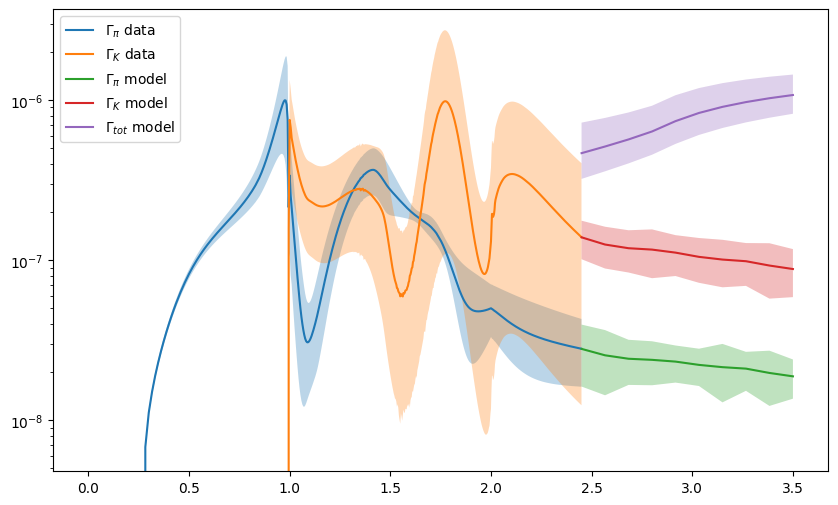

In [64]:
from decay_widths import gg_NNLO,ssbar_NNLO
def plot_decay_widths(m,data):
    fig,ax=plt.subplots(figsize=(10,6))

    gamma_tot=gamma_fac_opt*(gg_NNLO(m,m)+ssbar_NNLO(m,m))

    ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
    ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
    ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
    ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=br_pi*gamma_tot
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=br_K*gamma_tot
    pi_err=np.array([d['pi']['gamma std'] for d in data])
    K_err=np.array([d['K']['gamma std'] for d in data])
    #gamma_tot=np.array([d['total']['gamma mean'] for d in data])
    gamma_err=np.array([d['total']['gamma std'] for d in data])

    ax.plot(m,gamma_pi,label=r'$\Gamma_\pi$ model')
    ax.fill_between(m, gamma_pi-pi_err,gamma_pi+pi_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_K,label=r'$\Gamma_K$ model')
    ax.fill_between(m, gamma_K-K_err,gamma_K+K_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_tot,label=r'$\Gamma_{tot}$ model')
    #ax.fill_between(m, gamma_tot-gamma_err,gamma_tot+gamma_err,alpha=0.3,interpolate=True)
    ax.fill_between(m, gamma_fac_opt*(gg_NNLO(m,m*2)+ssbar_NNLO(m,m*2)),gamma_fac_opt*(gg_NNLO(m,m/2)+ssbar_NNLO(m,m/2)),alpha=0.3,interpolate=True)

    ax.set_yscale('log')
    ax.legend()
    plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths.pdf')

plot_decay_widths(m_error_fit*1e-3,all_brs)

In [21]:
def plot_br_with_error(state,brs,m,label):
    error=np.array([brs[i][state]['BR std'] for i in range(len(m))])
    mean=np.array([brs[i][state]['BR mean'] for i in range(len(m))])
    central=np.array([brs[i][state]['BR central'] for i in range(len(m))])
    #plt.plot(m,mean,label=label)
    plt.plot(m,central,label=label)
    plt.fill_between(m,central+error,central-error,alpha=0.3)
    plt.legend()

In [ ]:
plot_br_with_error((-211,211),all_brs,m_error_fit,label='pi+pi-')
plot_br_with_error((-321,321),all_brs,m_error_fit,label='K+K-')
plot_br_with_error((111,111,111,111),all_brs,m_error_fit,label='4pi0')
plot_br_with_error((-211,111,111,211),all_brs,m_error_fit,label='pi+pi-2pi0')
plot_br_with_error((-211,-211,211,211),all_brs,m_error_fit,label='2pi+2pi-')

### error from varying parameters in minos intervals

In [129]:
parameters_from_minos=[]
upper_lower_errors={'wv':[0,wv_opt+wv_upper],'ws':[0,ws_opt+ws_upper],'gamma_fac':[gamma_fac_opt-gamma_fac_lower,gamma_fac_opt+gamma_fac_upper]}
SH_err=ScalarHadronizer(scalar_mass=2450)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_err.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])

In [130]:
parameters_from_minos

[[0.0, 0.23925611172170444, 0.9997932359047892],
 [3.2674929442933327, 5.391713208714732e-09, 1.0129933901061048],
 [2.1095298725864464, 0.0, 0.9965044770067778],
 [2.5411686212846885e-06, 0.4730840406100597, 1.0169217623790334],
 [1.0123581452304231, 0.06533299322197197, 0.8942427881466334],
 [1.045450268411421, 0.10570972598116889, 1.1057571815246905]]

In [39]:
import networkx as nx
#error by varying parameters within minos error range
def compute_errors_from_par_variation(mass,par_list,optimal_values=[ws_opt,wv_opt,gamma_fac_opt],suppression_mode='spin'):
    SH_err=ScalarHadronizer(scalar_mass=mass,suppression_mode=suppression_mode)
    meson_list=SH_err.initialize_meson_list_for_parameter_fits()
    decay_graph_init, _ = SH_err.build_decay_graph(exclude_below_threshold=False)
    fs_keys = [s for s, d in decay_graph_init.out_degree() if d == 0]
    states_with_errors_temp={s:{'BR err':[],'gamma err':[]} for s in fs_keys+['pi','K','gamma total']}

    for pars in par_list:
        SH_err.set_parameters(strange_weight=pars[0],spin_suppression=pars[1],gamma_fac=pars[2])
        new_initial_states = SH_err.make_initialMesonPairs(exclude_below_threshold=False)
        reweighted_graph = SH_err.buildWeights(decay_graph_init, new_initial_states, fs_keys)
        branching_ratios = nx.get_node_attributes(reweighted_graph, 'weight')
        gam_tot = SH_err.get_decay_width(1) 
        for state in fs_keys:
            states_with_errors_temp[state]['BR err'].append(branching_ratios[state])
            states_with_errors_temp[state]['gamma err'].append(SH_err.get_decay_width(branching_ratios[state]))
        states_with_errors_temp['pi']['BR err'].append(branching_ratios[(-211,211)]+branching_ratios[(111,111)])
        states_with_errors_temp['K']['BR err'].append(branching_ratios[(-321,321)]+branching_ratios[(-311,311)])
        states_with_errors_temp['pi']['BR err'].append(branching_ratios[(-211,211)]+branching_ratios[(111,111)])
        states_with_errors_temp['pi']['gamma err'].append(SH_err.get_decay_width(branching_ratios[(-211,211)])+SH_err.get_decay_width(branching_ratios[(111,111)]))
        states_with_errors_temp['K']['gamma err'].append(SH_err.get_decay_width(branching_ratios[(-311,311)])+SH_err.get_decay_width(branching_ratios[(-321,321)]))
        states_with_errors_temp['gamma total']['gamma err'].append(SH_err.get_decay_width(1))

    #central values
    SH_err.set_parameters(strange_weight=optimal_values[0],spin_suppression=optimal_values[1],gamma_fac=optimal_values[2])
    new_initial_states = SH_err.make_initialMesonPairs(exclude_below_threshold=False)
    reweighted_graph = SH_err.buildWeights(decay_graph_init, new_initial_states, fs_keys)
    branching_ratios_central = nx.get_node_attributes(reweighted_graph, 'weight')
    gam_tot_central = SH_err.get_decay_width(1) 
    states_with_errors={s:{'BR central':0,'BR upper':0,'BR lower':0, 'gamma central':0,'gamma upper':0, 'gamma lower':0} for s in fs_keys+['pi','K','gamma total']}
    for state,errs in states_with_errors_temp.items():
        if state!='gamma total':
            try: states_with_errors[state]['BR upper']=max(states_with_errors_temp[state]['BR err'])
            except ValueError as e:
                print(state)
                print(states_with_errors_temp[state])
                raise e
            states_with_errors[state]['BR lower']=min(states_with_errors_temp[state]['BR err'])
        states_with_errors[state]['gamma upper']=max(states_with_errors_temp[state]['gamma err'])
        states_with_errors[state]['gamma lower']=min(states_with_errors_temp[state]['gamma err'])
        if state not in ['pi','K','gamma total']:
            states_with_errors[state]['BR central']=branching_ratios_central[state]
            states_with_errors[state]['gamma central']=SH_err.get_decay_width(branching_ratios_central[state])
    states_with_errors['pi']['BR central']=branching_ratios_central[(-211,211)]+branching_ratios_central[(111,111)]
    states_with_errors['K']['BR central']=branching_ratios_central[(-321,321)]+branching_ratios_central[(-311,311)]
    states_with_errors['pi']['gamma central']=SH_err.get_decay_width(branching_ratios_central[(-211,211)])+SH_err.get_decay_width(branching_ratios_central[(111,111)])
    states_with_errors['K']['gamma central']=SH_err.get_decay_width(branching_ratios_central[(-321,321)])+SH_err.get_decay_width(branching_ratios_central[(-311,311)])
    states_with_errors['gamma total']['gamma central']=SH_err.get_decay_width(1)
    return states_with_errors


In [168]:
m_error_fit=np.linspace(m_fit,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

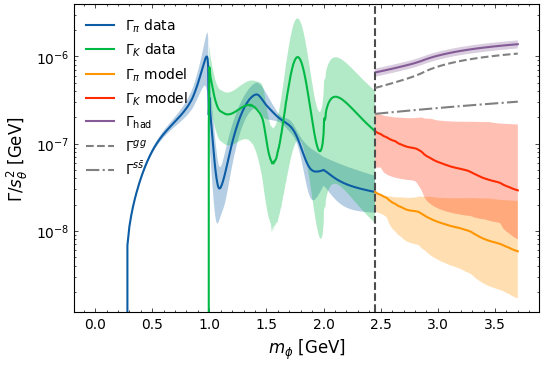

In [161]:
from decay_widths import gamma_gg,gamma_ss

def plot_errors_from_par_variation(plot_mass,data,gamma_fac,path):
    fig,ax=plt.subplots()
    gamma_had=gamma_fac*(gamma_gg(plot_mass)+gamma_ss(plot_mass))

    ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
    ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
    ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
    ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=np.array([d['pi']['gamma central'] for d in data])
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=np.array([d['K']['gamma central'] for d in data])
    pi_upper=np.array([d['pi']['gamma upper'] for d in data])
    pi_lower=np.array([d['pi']['gamma lower'] for d in data])
    K_upper=np.array([d['K']['gamma upper'] for d in data])
    K_lower=np.array([d['K']['gamma lower'] for d in data])
    gamma_upper=np.array([d['gamma total']['gamma upper'] for d in data])
    gamma_lower=np.array([d['gamma total']['gamma lower'] for d in data])

    ax.plot(plot_mass,gamma_pi,label=r'$\Gamma_\pi$ model')
    ax.fill_between(plot_mass, pi_lower,pi_upper,alpha=0.3,interpolate=True)
    ax.plot(plot_mass,gamma_K,label=r'$\Gamma_K$ model')
    ax.fill_between(plot_mass, K_lower,K_upper,alpha=0.3,interpolate=True)
    ax.plot(plot_mass,gamma_had,label=r'$\Gamma_\text{had}$')
    ax.fill_between(plot_mass, gamma_lower,gamma_upper,alpha=0.3,interpolate=True)
    ax.axvline(2.45, linestyle='--', color='0.3')

    ax.plot(plot_mass,gamma_fac*gamma_gg(plot_mass),linestyle='--',label=r'$\Gamma^{gg}$',color='grey')
    ax.plot(plot_mass,gamma_fac*gamma_ss(plot_mass),linestyle='-.',label=r'$\Gamma^{s\bar{s}}$',color='grey')
    ax.set_yscale('log')
    ax.set_xlabel(r'$m_\phi$ [GeV]')
    ax.set_ylabel(r'$\Gamma/s_\theta^2$ [GeV]')
    ax.legend(loc='upper left')
    plt.savefig(path)

plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,gamma_fac_opt,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error.pdf')

In [170]:
from decay_widths import gamma_hadrons,gamma_total
def plot_br_with_minos_error2(axis,state,brs,m,label):
    m=m*1e-3
    hadronic_br=gamma_hadrons(m)/gamma_total(m)
    upper=np.array([brs[i][state]['BR upper'] for i in range(len(m))])*hadronic_br
    lower=np.array([brs[i][state]['BR lower'] for i in range(len(m))])*hadronic_br
    central=np.array([brs[i][state]['BR central'] for i in range(len(m))])*hadronic_br
    axis.plot(m,central,label=label)
    axis.fill_between(m,upper,lower,alpha=0.3)
    axis.text(0.95, 0.95, label, horizontalalignment='right', verticalalignment='top', transform=axis.transAxes)
    #axis.legend()
    axis.set_xlabel(r'$m_\phi$ [GeV]')
    axis.set_ylabel('branching ratio')

def plot_br_with_minos_error(axis, state, brs, m, label):
    m = m * 1e-3
    hadronic_br = gamma_hadrons(m) / gamma_total(m)
    
    list_of_dicts = [
        brs[i][state] if state in brs[i].keys() else {'BR upper': 0, 'BR lower': 0, 'BR central': 0}
        for i in range(len(m)) ]
    upper = np.array([d['BR upper'] for d in list_of_dicts]) * hadronic_br
    lower = np.array([d['BR lower'] for d in list_of_dicts]) * hadronic_br
    central = np.array([d['BR central'] for d in list_of_dicts]) * hadronic_br
    
    axis.plot(m, central, label=label)
    axis.fill_between(m, upper, lower, alpha=0.3)
    axis.text(0.95, 0.95, label, horizontalalignment='right', verticalalignment='top', transform=axis.transAxes)
    axis.set_xlabel(r'$m_\phi$ [GeV]',fontsize=10)
    axis.set_ylabel('branching ratio',fontsize=10)

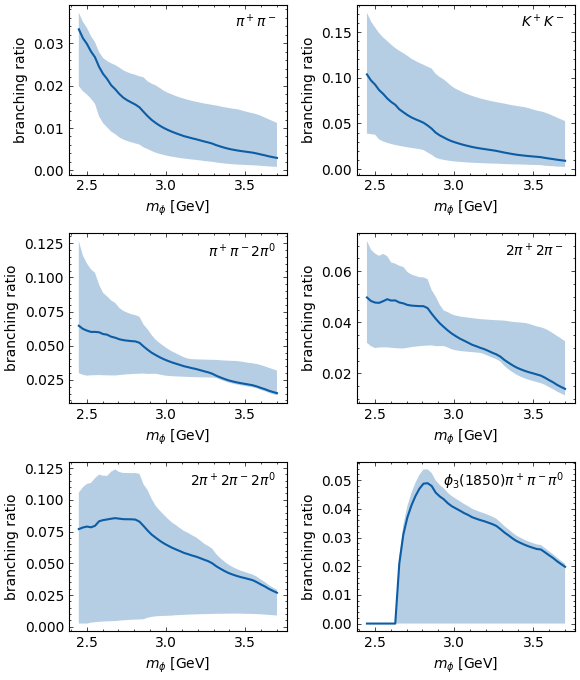

In [172]:
fig,ax=plt.subplots(3,2,figsize=(6,7))
plot_br_with_minos_error(ax[0,0],(-211,211),all_brs,m_error_fit,label=r'$\pi^+\pi^-$')
plot_br_with_minos_error(ax[0,1],(-321,321),all_brs,m_error_fit,label=r'$K^+K^-$')
plot_br_with_minos_error(ax[1,0],(-211,111,111,211),all_brs,m_error_fit,label=r'$\pi^+\pi^-2\pi^0$')
plot_br_with_minos_error(ax[1,1],(-211,-211,211,211),all_brs,m_error_fit,label=r'$2\pi^+2\pi^-$')
plot_br_with_minos_error(ax[2,0],(-211,-211,111,111,211,211),all_brs,m_error_fit,label=r'$2\pi^+2\pi^-2\pi^0$')
plot_br_with_minos_error(ax[2,1],(-211,111,211,337),all_brs,m_error_fit,label=r'$\phi_3(1850)\pi^+\pi^-\pi^0$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/brs_with_error.pdf')

/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/decay_widths.py:174: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-4*x)


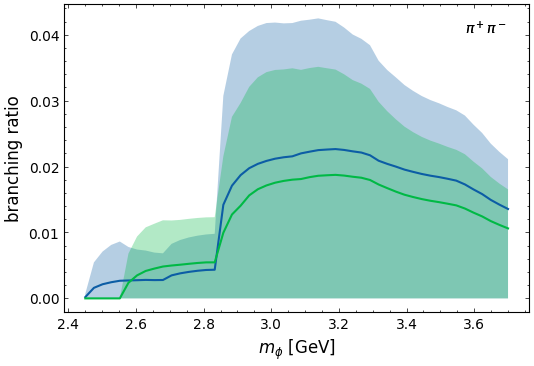

In [ ]:
#downwards kink around 2.8 is explained by many new thresholds appearing here
fig,ax=plt.subplots()
plot_br_with_minos_error(ax,(-211,111,211,227),all_brs,m_error_fit,label=r'$$')
plot_br_with_minos_error(ax,(-211,211,9010225),all_brs,m_error_fit,label=r'$$')

In [114]:
#look for thresholds
thresholds=[]
search_window=[2800,2900]
init_states=SH_best_fit2.get_initial_states()
count=0
for p1,p2 in init_states.keys():
    particle1=p.from_pdgid(p1)
    p1_mass=particle1.mass
    particle2=p.from_pdgid(p2)
    p2_mass=particle2.mass
    mass=p1_mass+p2_mass
    if mass>search_window[0] and mass<search_window[1]: 
        count+=1
        print(particle1.name,particle2.name,mass)

print(count)

f(2)(1270) eta(2)(1645) 2892.4
f(2)(1270) f(2)(1565) 2846.4
omega(3)(1670) h(1)(1170) 2833.0
K(2)*(1430)~0 K(2)*(1430)0 2864.8
K(2)*(1430)- K(2)*(1430)+ 2854.6
phi(1020) phi(3)(1850) 2873.4610000000002
a(0)(1450)0 a(0)(1450)0 2878.0
a(0)(1450)- a(0)(1450)+ 2878.0
f(0)(1370) f(0)(1500) 2872.0
h(1)(1170) omega(1650) 2836.0
eta(2)(1645) f(1)(1285) 2898.8
K(0)*(1430)~0 K(0)*(1430)0 2860.0
K(0)*(1430)- K(0)*(1430)+ 2860.0
h(1)(1415) h(1)(1415) 2818.0
a(1)(1260)0 pi(1)(1600)0 2875.0
a(1)(1260)0 a(1)(1640)0 2885.0
f(1)(1285) f(2)(1565) 2852.8
K(1)(1400)~0 K(1)(1400)0 2806.0
K(1)(1400)- K(1)(1400)+ 2806.0
f(1)(1420) f(1)(1420) 2856.8
omega(1420) omega(1420) 2820.0
K*(1410)~0 K*(1410)0 2828.0
K*(1410)- K*(1410)+ 2828.0
eta(1405) eta(1405) 2817.4
24


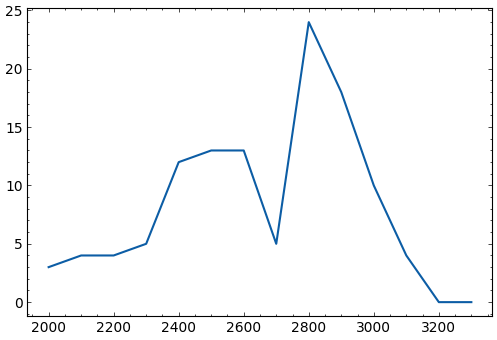

In [148]:
#24 new channels appear between 2800 and 2900 MeV
x_list=np.arange(2000,3400,100)
counts=[]
for x in x_list:
    count=0
    for p1,p2 in init_states.keys():
        particle1=p.from_pdgid(p1)
        p1_mass=particle1.mass
        particle2=p.from_pdgid(p2)
        p2_mass=particle2.mass
        mass=p1_mass+p2_mass 
        if mass>=x and mass<x+100: count+=1
    counts.append(count)

plt.plot(x_list,counts)

In [145]:
#which parameters correspnd to upper boundary of gamma_K?
i=0
for i in range(6):
    SH=ScalarHadronizer(scalar_mass=2450,strange_weight=parameters_from_minos[i][0],spin_suppression=parameters_from_minos[i][1],suppression_mode='spin',gamma_fac=parameters_from_minos[i][2])

    states=SH.make_initialMesonPairs(logging=True)
    print(states[(-321,321)]+states[(-311,311)])
    print(states[(-211,211)]+states[(111,111)])
    #print(SH.get_decay_width(states[(-321,321)]+states[(-311,311)]),gamma_ss(2.45))
#SH.print_initial_states()



0.12858618291080054
0.04488229697950966
0.30390113738886854
0.025378170511861614
0.35133776313786647
0.041895751544175686
0.08021862022524917
0.027937607181887054
0.23868699507798635
0.047750832260140895
0.19395096472783352
0.03862148870687195


In [146]:
SH=ScalarHadronizer(scalar_mass=2450,strange_weight=parameters_from_minos[i][0],spin_suppression=parameters_from_minos[i][1],suppression_mode='spin',gamma_fac=parameters_from_minos[i][2])
SH.simulateDecay()
len(SH.get_final_states())

Generated 47 initial meson pairs.


334

### version 2
set all parameters to minos boundary values at the same time, using all combinations of boundaries. Instead of setting one parameter to boundary and the others to optimum

In [49]:
parameters_from_minos2=[(ws_opt+ws_upper,wv_opt+wv_upper,gamma_fac_opt+gamma_fac_upper),
                        (ws_opt+ws_upper,wv_opt+wv_upper,gamma_fac_opt-gamma_fac_lower),
                        (ws_opt+ws_upper,0,gamma_fac_opt+gamma_fac_upper),
                        (ws_opt+ws_upper,0,gamma_fac_opt-gamma_fac_lower),
                        (0,wv_opt+wv_upper,gamma_fac_opt+gamma_fac_upper),
                        (0,wv_opt+wv_upper,gamma_fac_opt-gamma_fac_lower),
                        (0,0,gamma_fac_opt+gamma_fac_upper),
                        (0,0,gamma_fac_opt-gamma_fac_lower)]

In [55]:
m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_minos2.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos2)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

2450.0
Generated 49 initial meson pairs.
2566.6666666666665
Generated 68 initial meson pairs.
2683.3333333333335
Generated 80 initial meson pairs.
2800.0
Generated 99 initial meson pairs.
2916.6666666666665
Generated 131 initial meson pairs.
3033.3333333333335
Generated 155 initial meson pairs.
3150.0
Generated 178 initial meson pairs.
3266.666666666667
Generated 191 initial meson pairs.
3383.3333333333335
Generated 231 initial meson pairs.
3500.0
Generated 251 initial meson pairs.


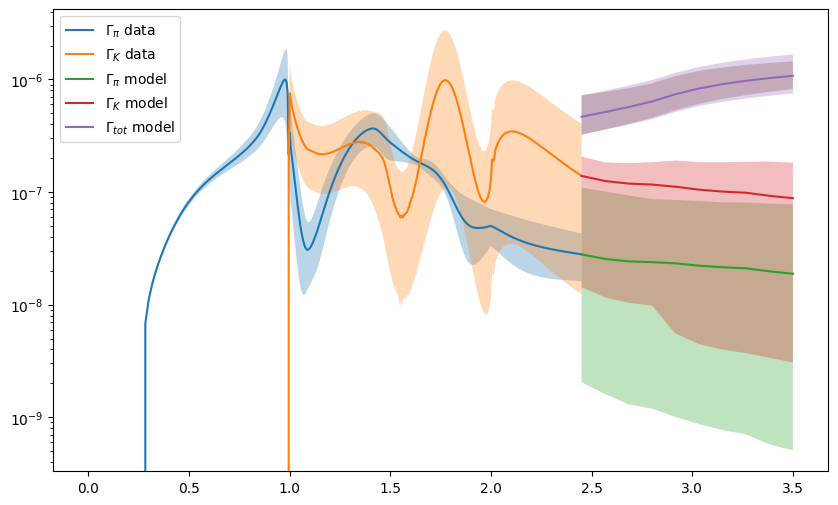

In [58]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error2.pdf')

## suppression_mode: OAM

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1111                     │              Nfcn = 269              │
│ EDM = 8.04e-05 (Goal: 0.0001)    │            time = 4.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │   0.23    │   0.70    │   -0.23    │    0.75    │    0    │   10    │       │
│ 1 │ wv        │  1.8e-6   │861395.6e-6│  -1.8e-6   │372609.7e-6 │    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.11    │   -0.10    │    0.11    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.23   │   0.75    │  -1.8e-6  │372609.7e-6│   -0.10   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │     0.529    -25e-6     0.016 │
│        wv │    -25e-6  7.34e-06      0e-6 │
│ gamma_fac │     0.016      0e-6    0.0111 │
└───────────┴───────────────────────────────┘

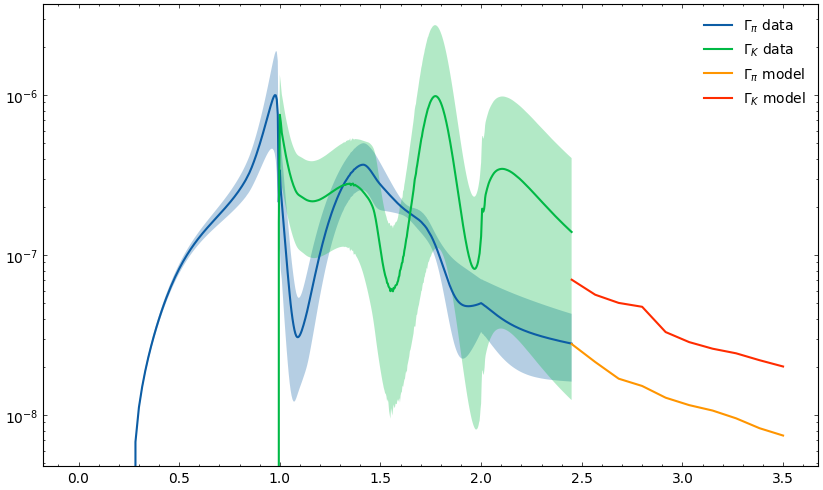

In [8]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='OAM')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_oam=m.params[0].value
wv_opt_oam=m.params[1].value
gamma_fac_opt_oam=m.params[2].value
cov_matrix_oam=np.array(m.covariance)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt_oam,spin_suppression=wv_opt_oam,suppression_mode='OAM',gamma_fac=gamma_fac_opt_oam)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt_oam,wv_opt_oam,gamma_fac_opt_oam,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()


In [64]:
ws_upper_oam=m.merrors['ws'].upper
wv_upper_oam=m.merrors['wv'].upper
gamma_fac_upper_oam=m.merrors['gamma_fac'].upper
gamma_fac_lower_oam=abs(m.merrors['gamma_fac'].lower)
likelihood_oam=m.fval

In [14]:
parameters_from_minos_oam=[]
upper_lower_errors={'wv':[0,wv_opt_oam+wv_upper_oam],'ws':[0,ws_opt_oam+ws_upper_oam],'gamma_fac':[gamma_fac_opt_oam-gamma_fac_lower_oam,gamma_fac_opt_oam+gamma_fac_upper_oam]}
SH_err=ScalarHadronizer(scalar_mass=2450,suppression_mode='OAM')
meson_list=SH_err.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_err.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos_oam.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])

In [15]:
parameters_from_minos_oam

[[0.0, 0.04483548518573668, 1.0009044404400085],
 [0.9764072297938056, 1.1251371276924885e-06, 1.019438596697834],
 [0.24010618059033498, 0.0, 1.0034625094165244],
 [4.090305193393503e-06, 0.3726115061774781, 1.0186524684580027],
 [0.063524073284487, 5.148222984515034e-06, 0.8981279872292391],
 [0.3779855481681281, 7.630976324549967e-07, 1.1088714122499337]]

In [173]:
m_error_fit=np.linspace(m_fit,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos_oam.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs_oam = pickle.load(f)
else:
    all_brs_oam=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_oam,optimal_values=[ws_opt_oam,wv_opt_oam,gamma_fac_opt_oam],suppression_mode='OAM')
        all_brs_oam.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs_oam,f)

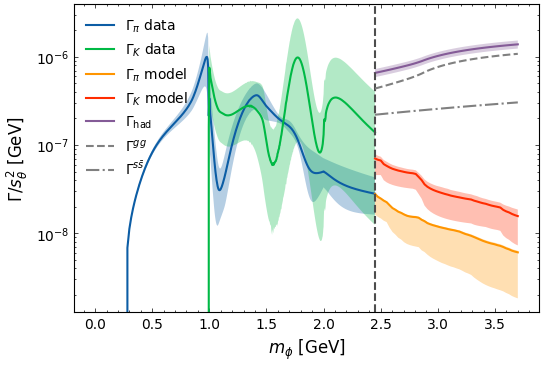

In [160]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs_oam,gamma_fac_opt_oam,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error_oam.pdf')

/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/decay_widths.py:174: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-4*x)


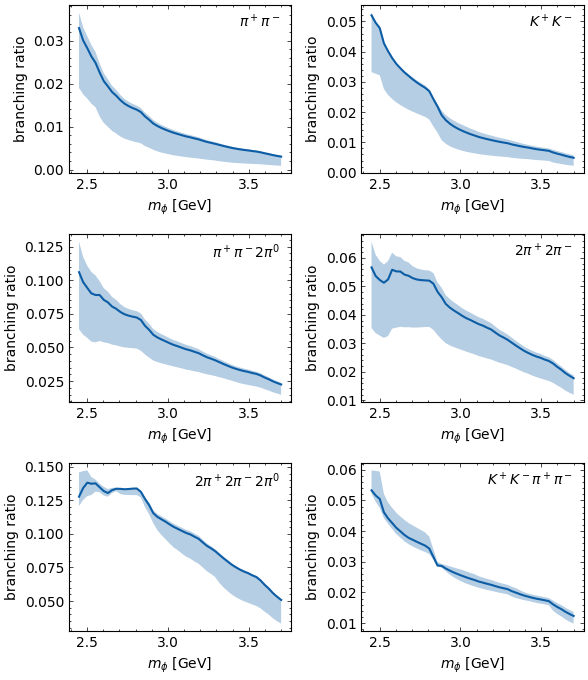

In [174]:
fig,ax=plt.subplots(3,2,figsize=(6,7))
plot_br_with_minos_error(ax[0,0],(-211,211),all_brs_oam,m_error_fit,label=r'$\pi^+\pi^-$')
plot_br_with_minos_error(ax[0,1],(-321,321),all_brs_oam,m_error_fit,label=r'$K^+K^-$')
plot_br_with_minos_error(ax[1,0],(-211,111,111,211),all_brs_oam,m_error_fit,label=r'$\pi^+\pi^-2\pi^0$')
plot_br_with_minos_error(ax[1,1],(-211,-211,211,211),all_brs_oam,m_error_fit,label=r'$2\pi^+2\pi^-$')
plot_br_with_minos_error(ax[2,0],(-211,-211,111,111,211,211),all_brs_oam,m_error_fit,label=r'$2\pi^+2\pi^-2\pi^0$')
plot_br_with_minos_error(ax[2,1],(-321,-211,211,321),all_brs_oam,m_error_fit,label=r'$K^+K^-\pi^+\pi^-$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/brs_with_error_oam.pdf')

2450 0.23062159202970628 1.7713710299790053e-06 1.0030918911122697
Generated 36 initial meson pairs.
Generated 124 initial meson pairs.


(<Figure size 400x500 with 1 Axes>, <Axes: xlabel='branching ratio'>)

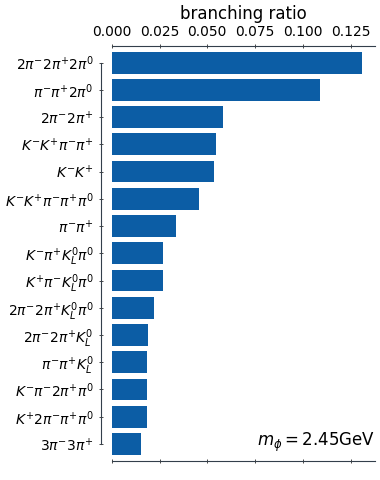

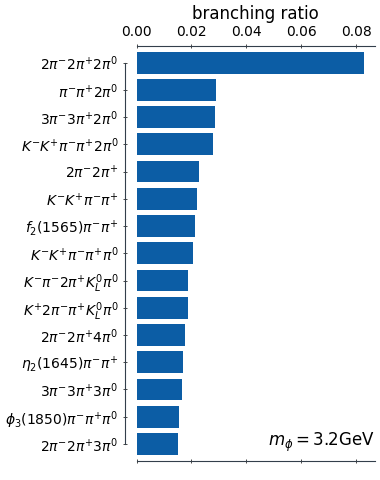

In [18]:
print(m_fit,ws_opt_oam,wv_opt_oam,gamma_fac_opt_oam)
SH_best_fit=ScalarHadronizer(scalar_mass=m_fit,strange_weight=ws_opt_oam,spin_suppression=wv_opt_oam,gamma_fac=gamma_fac_opt_oam,suppression_mode='OAM')
SH_best_fit.simulateDecay()
SH_best_fit.plot_final_state_hist(show=False,n=15,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist1_oam.pdf')
SH_best_fit2=ScalarHadronizer(scalar_mass=3200,strange_weight=ws_opt,spin_suppression=wv_opt,gamma_fac=gamma_fac_opt,suppression_mode='OAM')
SH_best_fit2.simulateDecay()
SH_best_fit2.plot_final_state_hist(show=False,n=15,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist2_oam.pdf')


(<Figure size 400x500 with 1 Axes>, <Axes: xlabel='branching ratio'>)

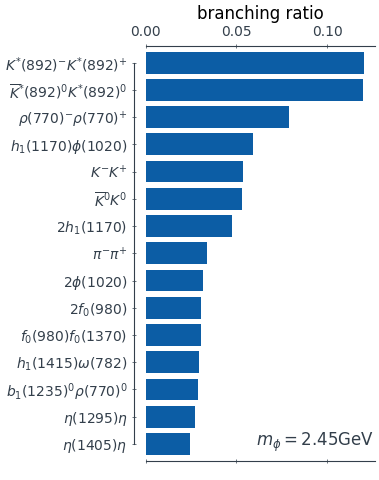

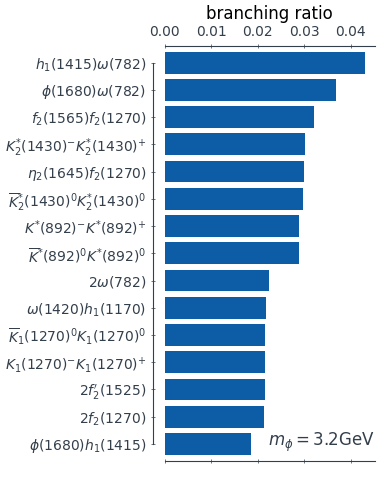

In [92]:
SH_best_fit.plot_initial_state_hist(n=15,show=False,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/initial_state_hist1_oam.pdf')
SH_best_fit2.plot_initial_state_hist(n=15,show=False,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/initial_state_hist2_oam.pdf')

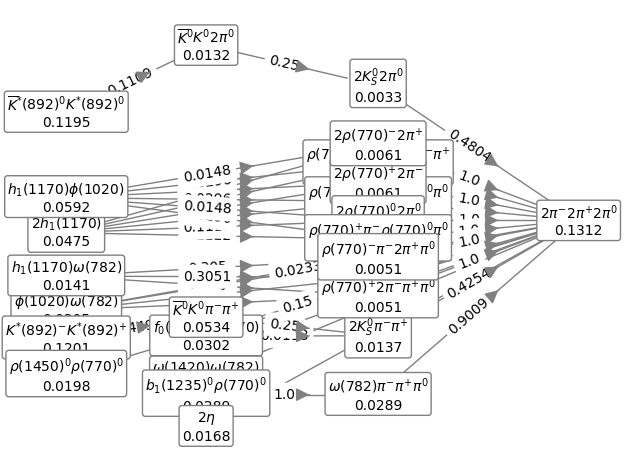

In [106]:
SH_best_fit.plot_from_final_state((-211,-211,111,111,211,211))

In [22]:
def get_contour(contour_name,par1,par2,cl=0.68,exp=False):
    file_path=f'pkls_for_plots/{contour_name}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            contour = pickle.load(f)
    else:
        if exp: contour=m.mncontour(par1,par2,cl=cl,experimental=True)
        else: contour=m.mncontour(par1,par2,interpolated=400,cl=cl)
        with open(file_path,'wb') as f:
            pickle.dump(contour,f)
    return contour

In [23]:
contour_wswv=get_contour('contour_wswv_oam','ws','wv')

In [25]:
contour_wsgamma=get_contour('contour_wsgamma_oam','ws','gamma_fac')

In [26]:
contour_wvgamma=get_contour('contour_wvgamma_oam','wv','gamma_fac')

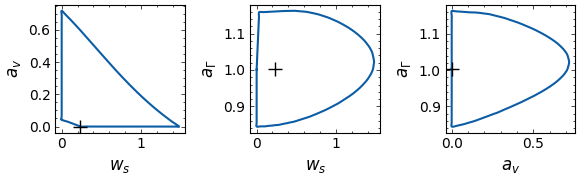

In [27]:
fig,axis=plt.subplots(1,3,figsize=(6,2))
axis[0].plot(contour_wswv[:,0],contour_wswv[:,1],label='68%')
axis[0].plot(ws_opt_oam,wv_opt_oam,'+',markersize=10,color='black')
axis[0].set_xlabel(r'$w_s$')
axis[0].set_ylabel(r'$a_v$')
axis[1].plot(contour_wsgamma[:,0],contour_wsgamma[:,1])
axis[1].plot(ws_opt_oam,gamma_fac_opt_oam,'+',markersize=10,color='black')
axis[1].set_xlabel(r'$w_s$')
axis[1].set_ylabel(r'$a_{\Gamma}$')
axis[2].plot(contour_wvgamma[:,0],contour_wvgamma[:,1])
axis[2].plot(wv_opt_oam,gamma_fac_opt_oam,'+',markersize=10,color='black')
axis[2].set_xlabel(r'$a_v$')
axis[2].set_ylabel(r'$a_{\Gamma}$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/likelihood_contours_oam.pdf')

In [65]:
results_dict['ws_oam']=ws_opt_oam
results_dict['av_oam']=wv_opt_oam
results_dict['a_gamma_oam']=gamma_fac_opt_oam
results_dict['likelihood_oam']=likelihood_oam

results_dict['ws_upper_oam']=ws_upper_oam
results_dict['av_upper_oam']=wv_upper_oam
results_dict['a_gamma_upper_oam']=gamma_fac_upper_oam
results_dict['a_gamma_lower_oam']=gamma_fac_lower_oam
for i in [1,2,3]:
    for j in [1,2,3]:
        name='c_oam'+str(i)+str(j)
        results_dict[name]=cov_matrix_oam[i-1,j-1]

write_result_to_file(results_dict)

## fix wv=1

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.669                      │              Nfcn = 108              │
│ EDM = 2.77e-08 (Goal: 0.0001)    │            time = 1.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │ 0.031e-6  │624256.789e-6│ -0.031e-6  │516290.475e-6│    0    │   10    │       │
│ 1 │ wv        │   1.000   │   0.005   │            │            │    0    │    1    │  yes  │
│ 2 │ gamma_fac │   1.03    │   0.12    │   -0.12    │    0.12    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          ws           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.031e-6 │516290.475e-6│   -0.12   │   0.12    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │  7.88e-08         0        -0 │
│        wv │         0         0     0.000 │
│ gamma_fac │        -0     0.000    0.0143 │
└───────────┴───────────────────────────────┘

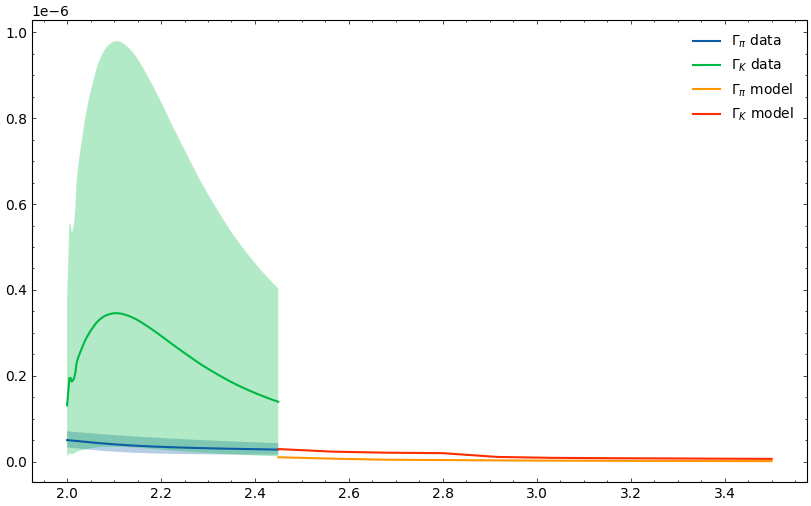

In [162]:
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='spin')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)
m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=0.8)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.fixto('wv',1)
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_fixed_wv=m.params[0].value
wv_opt_fixed_wv=m.params[1].value
gamma_fac_opt_fixed_wv=m.params[2].value
cov_matrix2=np.array(m.covariance)

ws_upper_fixed_wv=m.merrors['ws'].upper
gamma_fac_upper_fixed_wv=m.merrors['gamma_fac'].upper
gamma_fac_lower_fixed_wv=abs(m.merrors['gamma_fac'].lower)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt_fixed_wv,spin_suppression=wv_opt_fixed_wv,suppression_mode='spin',gamma_fac=gamma_fac_opt_fixed_wv)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt_fixed_wv,wv_opt_fixed_wv,gamma_fac_opt_fixed_wv,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
c=400
ax.plot(pi_data[c:,0],pi_data[c:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[c:,0], pi_data[c:,2],pi_data[c:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[c:,0],K_data[c:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[c:,0], K_data[c:,2],K_data[c:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
#ax.set_yscale('log')
plt.legend()

In [70]:
likelihood_fixed_wv=m.fval
results_dict['ws_fixed']=ws_opt_fixed_wv
results_dict['a_gamma_fixed']=gamma_fac_opt_fixed_wv
results_dict['likelihood_fixed']=likelihood_fixed_wv

results_dict['ws_upper_fixed']=ws_upper_fixed_wv
results_dict['a_gamma_upper_fixed']=gamma_fac_upper_fixed_wv
results_dict['a_gamma_lower_fixed']=gamma_fac_lower_fixed_wv

write_result_to_file(results_dict)

(<Figure size 400x600 with 1 Axes>, <Axes: xlabel='branching ratio'>)

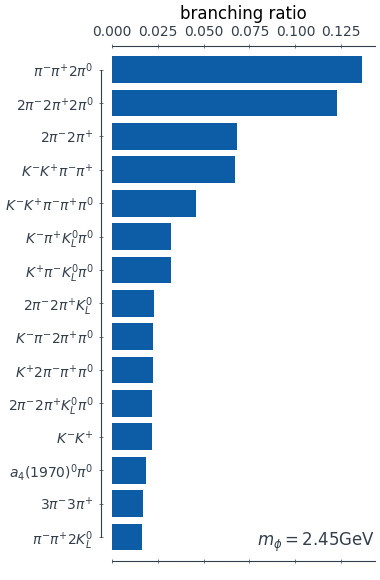

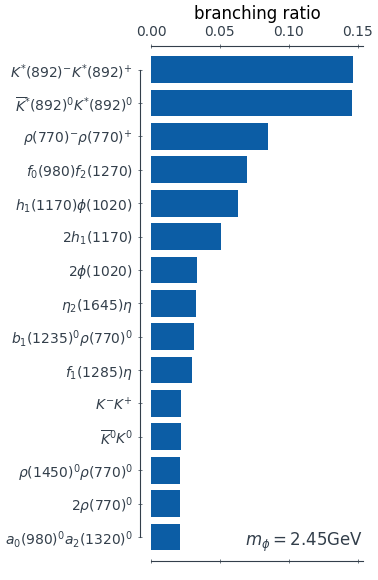

In [78]:
#SH_best_fit=ScalarHadronizer(scalar_mass=m_fit,strange_weight=ws_opt_fixed_wv,spin_suppression=wv_opt_fixed_wv,gamma_fac=gamma_fac_opt_fixed_wv)
#SH_best_fit.simulateDecay()
SH_best_fit.plot_final_state_hist(show=False,n=15,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist1_fixed_wv.pdf')
SH_best_fit.plot_initial_state_hist(n=15,show=False,save_path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/initial_state_hist1_fixed_wv.pdf')

In [46]:
fs=SH_best_fit.get_final_states()
print(fs[(-321,321)])
print(fs[(-211,211)])

0.02174097897361282
0.01208383770654131


### minos errors

In [115]:
parameters_from_minos_fixed_wv=[]
upper_lower_errors={'ws':[0,ws_opt_fixed_wv+ws_upper_fixed_wv],'gamma_fac':[gamma_fac_opt_fixed_wv-gamma_fac_lower_fixed_wv,gamma_fac_opt_fixed_wv+gamma_fac_upper_fixed_wv]}
SH_err=ScalarHadronizer(scalar_mass=2450)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()
def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.fixto('wv',1)
        minuit_error.migrad()
        parameters_from_minos_fixed_wv.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])
    
parameters_from_minos_fixed_wv

[[0.0, 1.0, 1.0222056310041914],
 [0.5170322989619783, 1.0, 1.0207735565940956],
 [6.722590607750661e-08, 1.0, 0.9170906851796231],
 [3.0271707721594987e-06, 1.0, 1.1267147352566895]]

In [164]:
m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_minos_fixedwv.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_fixed_wv,optimal_values=[ws_opt_fixed_wv,wv_opt_fixed_wv,gamma_fac_opt_fixed_wv])
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

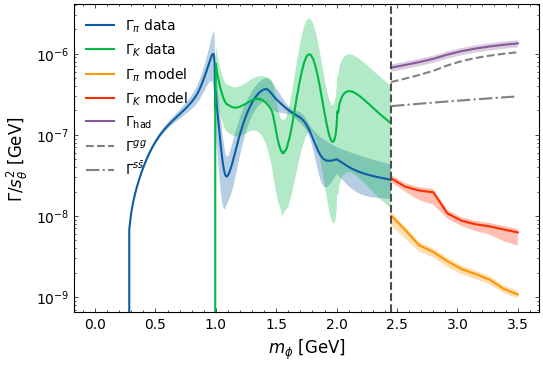

In [165]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,gamma_fac_opt_fixed_wv,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_fixed_av.pdf')

/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/decay_widths.py:174: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-4*x)


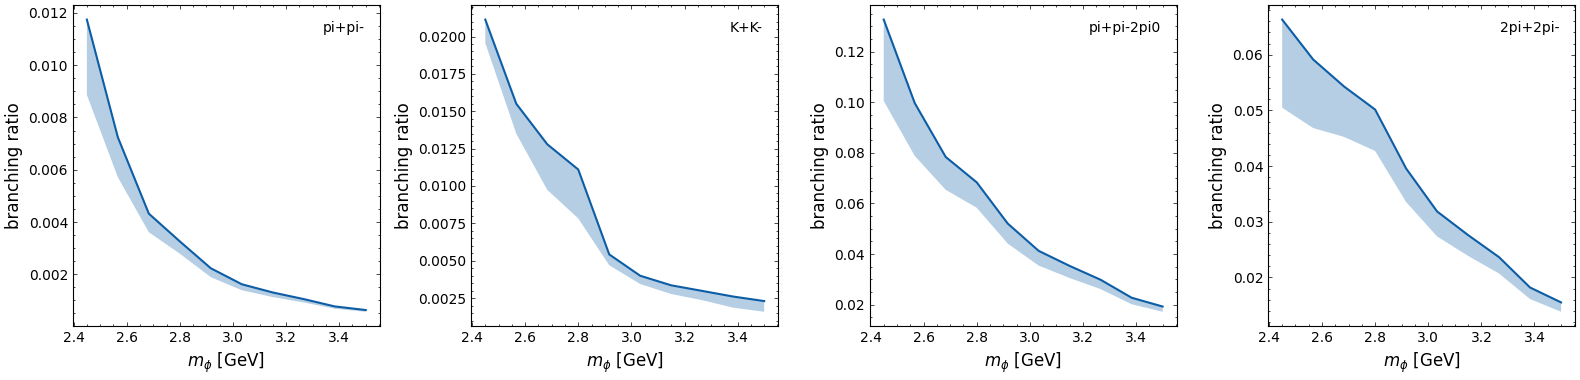

In [118]:
fig,ax=plt.subplots(1,4,figsize=(16,4))
plot_br_with_minos_error(ax[0],(-211,211),all_brs,m_error_fit,label='pi+pi-')
plot_br_with_minos_error(ax[1],(-321,321),all_brs,m_error_fit,label='K+K-')
plot_br_with_minos_error(ax[2],(-211,111,111,211),all_brs,m_error_fit,label='pi+pi-2pi0')
plot_br_with_minos_error(ax[3],(-211,-211,211,211),all_brs,m_error_fit,label='2pi+2pi-')
plt.tight_layout()

# cut at 2gev

In [9]:
from decay_widths import gamma_gg,gamma_ss
m_fit=2000
m_fit_gev=m_fit*1e-3
gamma_had_central=gamma_gg(m_fit_gev)+gamma_ss(m_fit_gev)
gamma_had_err=np.abs(gamma_had_central-gamma_gg(m_fit_gev,mu=2*m_fit_gev)-gamma_ss(m_fit_gev,mu=2*m_fit_gev))
gamma_had_upper=gamma_had_central+gamma_had_err
gamma_had_lower=gamma_had_central-gamma_had_err
print(gamma_had_central,gamma_had_err)

4.990619940976443e-07 6.047007475293422e-08


## spin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.693e-06                  │              Nfcn = 301              │
│ EDM = 5.68e-06 (Goal: 0.0001)    │            time = 2.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │    0.4    │    1.0    │    -0.4    │    1.4     │    0    │   10    │       │
│ 1 │ wv        │   0.18    │   0.31    │   -0.18    │    0.43    │    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.12    │   -0.12    │    0.12    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.4    │    1.4    │   -0.18   │   0.43    │   -0.12   │   0.12    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │       1.1     -0.34     0.001 │
│        wv │     -0.34     0.127     0.006 │
│ gamma_fac │     0.001     0.006    0.0147 │
└───────────┴───────────────────────────────┘

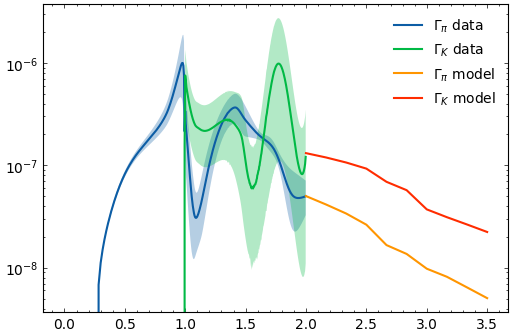

In [10]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2000
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='spin')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_at2=m.params[0].value
wv_opt_at2=m.params[1].value
gamma_fac_opt_at2=m.params[2].value
ws_upper_at2=m.merrors['ws'].upper
wv_upper_at2=m.merrors['wv'].upper
gamma_fac_upper_at2=m.merrors['gamma_fac'].upper
gamma_fac_lower_at2=abs(m.merrors['gamma_fac'].lower)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt_at2,spin_suppression=wv_opt_at2,suppression_mode='spin',gamma_fac=gamma_fac_opt_at2)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt_at2,wv_opt_at2,gamma_fac_opt_at2,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(6,4))
cutoff_ind=400
ax.plot(pi_data[:cutoff_ind,0],pi_data[:cutoff_ind,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:cutoff_ind,0], pi_data[:cutoff_ind,2],pi_data[:cutoff_ind,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:cutoff_ind,0],K_data[:cutoff_ind,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:cutoff_ind,0], K_data[:cutoff_ind,2],K_data[:cutoff_ind,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()
#plt.savefig('/home/henry/Documents/Uni/Masterarbeit/pi_K_decay_widths_at2.pdf')

In [12]:
print(ws_opt_at2,wv_opt_at2,gamma_fac_opt_at2)
print(ws_upper_at2,wv_upper_at2,gamma_fac_upper_at2,gamma_fac_lower_at2)

0.38763180043427553 0.17622492827502345 1.000210551346759
1.4416976196915452 0.434974120126236 0.12095756621435004 0.12137886767446096


In [37]:
parameters_from_minos_at2=[]
upper_lower_errors={'wv':[0,wv_opt_at2+wv_upper_at2],'ws':[0,ws_opt_at2+ws_upper_at2],'gamma_fac':[gamma_fac_opt_at2-gamma_fac_lower_at2,gamma_fac_opt_at2+gamma_fac_upper_at2]}
SH_err=ScalarHadronizer(scalar_mass=2000)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()
def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos_at2.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])
    
parameters_from_minos_at2

[[0.0, 0.3329169640576708, 0.9994208742179256],
 [1.827431339516807, 6.462328527778949e-06, 1.009895363052309],
 [1.2306841210680102, 0.0, 0.991738249508616],
 [7.224266513781649e-11, 0.6082302993547183, 1.0221439572418223],
 [0.3749845770710823, 0.13549695899221975, 0.894241940170071],
 [0.38927339577553394, 0.22057893087000122, 1.1057579464466185]]

In [24]:
m_error_fit=np.linspace(2000,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos_at2_spin.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs_at2_spin = pickle.load(f)
else:
    all_brs_oam=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_at2,optimal_values=[ws_opt_at2,wv_opt_at2,gamma_fac_opt_at2],suppression_mode='spin')
        all_brs_at2_spin.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs_at2_spin,f)

## oam

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03932                    │              Nfcn = 298              │
│ EDM = 3.06e-06 (Goal: 0.0001)    │            time = 2.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │   0.22    │   0.36    │   -0.21    │    0.43    │    0    │   10    │       │
│ 1 │ wv        │  0.05e-6  │905979.82e-6│  -0.05e-6  │504832.80e-6│    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.12    │   -0.12    │    0.12    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.21   │   0.43    │ -0.05e-6  │504832.80e-6│   -0.12   │   0.12    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │     0.134  -0.26e-6     0.013 │
│        wv │  -0.26e-6  2.73e-07         0 │
│ gamma_fac │     0.013         0    0.0144 │
└───────────┴───────────────────────────────┘

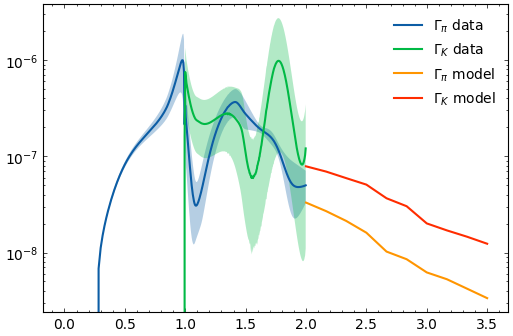

In [11]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2000
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='OAM')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_at2_oam=m.params[0].value
wv_opt_at2_oam=m.params[1].value
gamma_fac_opt_at2_oam=m.params[2].value
ws_upper_at2_oam=m.merrors['ws'].upper
wv_upper_at2_oam=m.merrors['wv'].upper
gamma_fac_upper_at2_oam=m.merrors['gamma_fac'].upper
gamma_fac_lower_at2_oam=abs(m.merrors['gamma_fac'].lower)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt_at2,spin_suppression=wv_opt_at2,suppression_mode='OAM',gamma_fac=gamma_fac_opt_at2)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt_at2,wv_opt_at2,gamma_fac_opt_at2,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(6,4))
cutoff_ind=400
ax.plot(pi_data[:cutoff_ind,0],pi_data[:cutoff_ind,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:cutoff_ind,0], pi_data[:cutoff_ind,2],pi_data[:cutoff_ind,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:cutoff_ind,0],K_data[:cutoff_ind,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:cutoff_ind,0], K_data[:cutoff_ind,2],K_data[:cutoff_ind,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()
#plt.savefig('/home/henry/Documents/Uni/Masterarbeit/pi_K_decay_widths_at2.pdf')

In [55]:
parameters_from_minos_at2_oam=[]
upper_lower_errors={'wv':[0,wv_opt_at2_oam+wv_upper_at2_oam],'ws':[0,ws_opt_at2_oam+ws_upper_at2_oam],'gamma_fac':[gamma_fac_opt_at2_oam-gamma_fac_lower_at2_oam,gamma_fac_opt_at2_oam+gamma_fac_upper_at2_oam]}
SH_err=ScalarHadronizer(scalar_mass=2000,suppression_mode='OAM')
meson_list=SH_err.initialize_meson_list_for_parameter_fits()
def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central,gamma_pi_upper,gamma_pi_lower)-logL_model(gamma_K,gamma_K_central,gamma_K_upper,gamma_K_lower)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos_at2_oam.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])
    
parameters_from_minos_at2_oam

[[0.0, 0.13327799581194424, 1.000435777710788],
 [0.6442304888305952, 3.3424771074574196e-08, 1.0246694315476317],
 [0.21406190342110568, 0.0, 1.0035042482553762],
 [6.25863772157724e-10, 0.500800236809318, 1.0226190665230326],
 [0.1190627746532185, 3.5144484761620576e-11, 0.8984365346931106],
 [0.3042883442770439, 2.533357511312964e-08, 1.1082634847551132]]

In [13]:
m_error_fit=np.linspace(2000,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos_at2_oam.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs_at2_oam = pickle.load(f)
else:
    all_brs_at2_oam=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_at2_oam,optimal_values=[ws_opt_at2_oam,wv_opt_at2_oam,gamma_fac_opt_at2_oam],suppression_mode='OAM')
        all_brs_at2_oam.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs_at2_oam,f)

In [14]:
print(ws_opt_at2,wv_opt_at2,gamma_fac_opt_at2)
print(ws_upper_at2,wv_upper_at2,gamma_fac_upper_at2,gamma_fac_lower_at2)
print(m.fval)

0.38763180043427553 0.17622492827502345 1.000210551346759
1.4416976196915452 0.434974120126236 0.12095756621435004 0.12137886767446096
0.03932462343867455


## plot

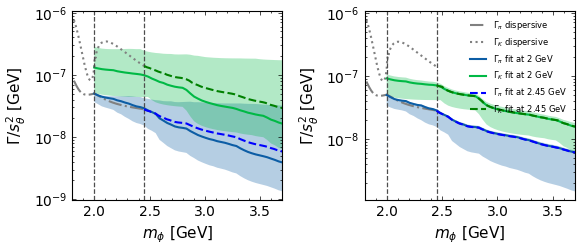

In [147]:
from decay_widths import gamma_gg,gamma_ss

fig,ax=plt.subplots(1,2,figsize=(6,2.7))
plot_mass=m_error_fit*1e-3
"""
ax[0].fill_between(pi_data[:400,0], pi_data[:400,2],pi_data[:400,3],alpha=0.3,interpolate=True)
ax[0].fill_between(K_data[:400,0], K_data[:400,2],K_data[:400,3],alpha=0.3,interpolate=True)
"""
cutoff=330
ax[0].plot(pi_data[cutoff:,0],pi_data[cutoff:,1],linestyle='-.',color='grey')
ax[0].plot(K_data[cutoff:,0],K_data[cutoff:,1],linestyle=':',color='grey')

def get_plotable_data(data):
    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=np.array([d['pi']['gamma central'] for d in data])
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=np.array([d['K']['gamma central'] for d in data])
    pi_upper=np.array([d['pi']['gamma upper'] for d in data])
    pi_lower=np.array([d['pi']['gamma lower'] for d in data])
    K_upper=np.array([d['K']['gamma upper'] for d in data])
    K_lower=np.array([d['K']['gamma lower'] for d in data])
    gamma_upper=np.array([d['gamma total']['gamma upper'] for d in data])
    gamma_lower=np.array([d['gamma total']['gamma lower'] for d in data])
    return br_pi,gamma_pi,br_K,gamma_K,pi_upper,pi_lower,K_upper,K_lower,gamma_upper,gamma_lower

br_pi,gamma_pi,br_K,gamma_K,pi_upper,pi_lower,K_upper,K_lower,gamma_upper,gamma_lower=get_plotable_data(all_brs_at2_spin)
ax[0].plot(plot_mass,gamma_pi)
ax[0].fill_between(plot_mass, pi_lower,pi_upper,alpha=0.3,interpolate=True)
ax[0].plot(plot_mass,gamma_K)
ax[0].fill_between(plot_mass, K_lower,K_upper,alpha=0.3,interpolate=True)
ax[0].axvline(2.45, linestyle='--', color='0.3',linewidth=0.9)
ax[0].axvline(2, linestyle='--', color='0.3',linewidth=0.9)

plot_mass=np.linspace(2450,3700,50)*1e-3
file_path = 'pkls_for_plots/brs_with_errors_minos.pkl'
with open(file_path, 'rb') as f:
    all_brs_spin = pickle.load(f)

br_pi,gamma_pi,br_K,gamma_K,pi_upper,pi_lower,K_upper,K_lower,gamma_upper,gamma_lower=get_plotable_data(all_brs_spin)
ax[0].plot(plot_mass,gamma_pi,linestyle='--',color='blue')
ax[0].plot(plot_mass,gamma_K,linestyle='--',color='green')

ax[0].set_yscale('log')
ax[0].set_xlim(1.8,3.7)
ax[0].set_xlabel(r'$m_\phi$ [GeV]',fontsize=11)
ax[0].set_ylabel(r'$\Gamma/s_\theta^2$ [GeV]',fontsize=11)
#fig.legend()


ax[1].plot(pi_data[cutoff:,0],pi_data[cutoff:,1],label=r'$\Gamma_\pi$ dispersive',linestyle='-.',color='grey')
ax[1].plot(K_data[cutoff:,0],K_data[cutoff:,1],label=r'$\Gamma_K$ dispersive',linestyle=':',color='grey')

plot_mass=m_error_fit*1e-3
br_pi,gamma_pi,br_K,gamma_K,pi_upper,pi_lower,K_upper,K_lower,gamma_upper,gamma_lower=get_plotable_data(all_brs_at2_oam)
ax[1].plot(plot_mass,gamma_pi,label=r'$\Gamma_\pi$ fit at 2 GeV')
ax[1].fill_between(plot_mass, pi_lower,pi_upper,alpha=0.3,interpolate=True)
ax[1].plot(plot_mass,gamma_K,label=r'$\Gamma_K$ fit at 2 GeV')
ax[1].fill_between(plot_mass, K_lower,K_upper,alpha=0.3,interpolate=True)
ax[1].axvline(2.45, linestyle='--', color='0.3',linewidth=0.9)
ax[1].axvline(2, linestyle='--', color='0.3',linewidth=0.9)

plot_mass=np.linspace(2450,3700,50)*1e-3
file_path = 'pkls_for_plots/brs_with_errors_minos_oam.pkl'
with open(file_path, 'rb') as f:
    all_brs_spin = pickle.load(f)

br_pi,gamma_pi,br_K,gamma_K,pi_upper,pi_lower,K_upper,K_lower,gamma_upper,gamma_lower=get_plotable_data(all_brs_spin)
ax[1].plot(plot_mass,gamma_pi,label=r'$\Gamma_\pi$ fit at 2.45 GeV',linestyle='--',color='blue')
ax[1].plot(plot_mass,gamma_K,label=r'$\Gamma_K$ fit at 2.45 GeV',linestyle='--',color='green')

ax[1].set_xlim(1.8,3.7)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$m_\phi$ [GeV]',fontsize=11)
ax[1].set_ylabel(r'$\Gamma/s^2_\theta$ [GeV]',fontsize=11)
ax[1].legend(loc='upper right', fontsize=6,ncol=1)
# fig.legend(loc='outside center')
plt.tight_layout()
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels,loc='outside upper center', ncol=3, fontsize=10,frameon=True)
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/fit_at2_comparison.pdf')
plt.show()


# ten lowest mass final states

In [42]:
mesons=p.findall(lambda x: x.pdgid.is_meson and x.mass<2000)
mesons = sorted(mesons, key=lambda x: x.mass)


def is_neutral(p):
    return p.anti_flag.name=='Same'

def are_antiparticles(p1,p2):
    return int(p1.pdgid)==-int(p2.pdgid)

def check_meson_combinations( m1, m2):

    # Check C conservation for particle - antiparticle
    if (not is_neutral(m1) or not is_neutral(m2)) and not are_antiparticles(m1, m2): return False

    # Check C and P for neutral mesons
    if is_neutral(m1) and is_neutral(m2):
            if m1.C!=m2.C: return False                                                                      #check charge conjugation eigenvalue
            if m1.J==0 and m2.J==0 and m1.P!=m2.P: return False
            if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P: return False            #parity must be opposite for l=1
            if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P: return False                 #parity must be same for l=2
            if ((m1.J==3 and m2.J==0) or (m1.J==0 and m2.J==3)) and m1.P!=(-1)*m2.P: return False            #parity must be opposite for l=3

    # Check isospin conservation
    if m1.I != m2.I: return False
    return True

In [51]:
pairs_charged=[]
pairs_neutral=[]
for i,m1 in enumerate(mesons):
    for m2 in mesons[i:]:
        if m1.charge!=0 and (m1.charge==(-1)*m2.charge) and ((m1.pdgid.has_strange and m2.pdgid.has_strange) or (not m1.pdgid.has_strange and not m2.pdgid.has_strange)):
            pairs_charged.append((m1,m2))
        if m1.charge==0 and m2.charge==0 and ((m1.pdgid.has_strange and m2.pdgid.has_strange) or (not m1.pdgid.has_strange and not m2.pdgid.has_strange)):
            pairs_neutral.append((m1,m2))
pairs_charged = sorted(pairs_charged, key=lambda x: x[0].mass + x[1].mass)
pairs_neutral = sorted(pairs_neutral, key=lambda x: x[0].mass + x[1].mass)
for pair in pairs_charged:
    print(*pair, pair[0].mass+pair[1].mass,check_meson_combinations(pair[0],pair[1]))
    print(f'\tC: {pair[0].C} {pair[1].C}, P: {pair[0].P} {pair[1].P}, I: {pair[0].I} {pair[1].I}, J: {pair[0].J} {pair[1].J}')
    m1=pair[0]
    m2=pair[1]
    if m1.C!=m2.C: print('\tC wrong')                                                                      #check charge conjugation eigenvalue
    if m1.J==0 and m2.J==0 and m1.P!=m2.P: print('\tP wrong')
    if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P:print('\tP wrong')
    if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P:print('\tP wrong')
    if ((m1.J==3 and m2.J==0) or (m1.J==0 and m2.J==3)) and m1.P!=(-1)*m2.P: print('\tP wrong')
    if m1.I != m2.I: print('\tI wrong')

pi+ pi- 279.14078 True
	C: 5 5, P: -1 -1, I: 1.0 1.0, J: 0.0 0.0
pi+ rho(770)- 914.68039 False
	C: 5 5, P: -1 -1, I: 1.0 1.0, J: 0.0 1.0
	P wrong
pi- rho(770)+ 914.68039 False
	C: 5 5, P: -1 -1, I: 1.0 1.0, J: 0.0 1.0
	P wrong
K+ K- 987.354 True
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
pi+ a(0)(980)- 1119.57039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 0.0
	P wrong
pi- a(0)(980)+ 1119.57039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 0.0
	P wrong
K+ K(0)*(700)- 1338.6770000000001 False
	C: 5 5, P: -1 1, I: 0.5 0.5, J: 0.0 0.0
	P wrong
K- K(0)*(700)+ 1338.6770000000001 False
	C: 5 5, P: -1 1, I: 0.5 0.5, J: 0.0 0.0
	P wrong
pi+ b(1)(1235)- 1369.07039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 1.0
pi- b(1)(1235)+ 1369.07039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 1.0
pi+ a(1)(1260)- 1369.57039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 1.0
pi- a(1)(1260)+ 1369.57039 False
	C: 5 5, P: -1 1, I: 1.0 1.0, J: 0.0 1.0
K+ K*(892)- 1385.347 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 1.0
	P 

In [52]:
for pair in pairs_neutral:
    print(*pair, pair[0].mass+pair[1].mass,check_meson_combinations(pair[0],pair[1]))
    print(f'\tC: {pair[0].C} {pair[1].C}, P: {pair[0].P} {pair[1].P}, I: {pair[0].I} {pair[1].I}, J: {pair[0].J} {pair[1].J}')
    m1=pair[0]
    m2=pair[1]
    if m1.C!=m2.C: print('\tC wrong')
    if m1.J==0 and m2.J==0 and m1.P!=m2.P: print('\tP wrong')
    if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P:print('\tP wrong')
    if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P:print('\tP wrong')
    if ((m1.J==3 and m2.J==0) or (m1.J==0 and m2.J==3)) and m1.P!=(-1)*m2.P: print('\tP wrong')
    if m1.I != m2.I: print('\tI wrong')

pi0 pi0 269.9536 True
	C: 1 1, P: -1 -1, I: 1.0 1.0, J: 0.0 0.0
pi0 eta 682.8388 False
	C: 1 1, P: -1 -1, I: 1.0 0.0, J: 0.0 0.0
	I wrong
pi0 f(0)(500) 734.9768 False
	C: 1 1, P: -1 1, I: 1.0 0.0, J: 0.0 0.0
	P wrong
	I wrong
pi0 rho(770)0 910.2368 False
	C: 1 -1, P: -1 -1, I: 1.0 1.0, J: 0.0 1.0
	C wrong
	P wrong
pi0 omega(782) 917.6368 False
	C: 1 -1, P: -1 -1, I: 1.0 0.0, J: 0.0 1.0
	C wrong
	P wrong
	I wrong
K(L)0 K(L)0 995.222 True
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(L)0 K(S)0 995.222 True
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(L)0 K0 995.222 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(L)0 K~0 995.222 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(S)0 K(S)0 995.222 True
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(S)0 K0 995.222 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K(S)0 K~0 995.222 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K0 K0 995.222 False
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0.0
K0 K~0 995.222 True
	C: 5 5, P: -1 -1, I: 0.5 0.5, J: 0.0 0

In [40]:
amesons=p.findall('a(0)')
check_meson_combinations(amesons[4],amesons[5])


True

In [41]:
SH=ScalarHadronizer(2000)
SH.print_initial_states()

The following initial states were generated:
K*(892)-[-323] K*(892)+[323]: 0.2001351127348537
omega(782)[223] omega(782)[223]: 0.19916319261004126
K*(892)~0[-313] K*(892)0[313]: 0.1967198002871363
rho(770)-[-213] rho(770)+[213]: 0.09122784272576709
omega(782)[223] phi(1020)[333]: 0.061445946970185426
K-[-321] K+[321]: 0.042719473912513954
K~0[-311] K0[311]: 0.04260919138933814
eta[221] f(1)(1285)[20223]: 0.0232121032558395
rho(770)0[113] rho(770)0[113]: 0.022800316646903754
pi-[-211] pi+[211]: 0.01588603225571862
pi0[111] a(1)(1260)0[20113]: 0.014718209027128273
pi0[111] pi(2)(1670)0[10115]: 0.011051462113085844
eta'(958)[331] eta'(958)[331]: 0.010221238851523361
eta[221] eta'(958)[331]: 0.010213839538123572
eta[221] eta[221]: 0.00825778842381485
eta[221] eta(1295)[100221]: 0.007447499408779696
omega(782)[223] h(1)(1170)[10223]: 0.007379670037138679
pi0[111] a(1)(1640)0[9020113]: 0.006976751481152214
eta[221] f(1)(1420)[20333]: 0.006206289714601627
pi0[111] pi(1300)0[100111]: 0.0045416

Generated 47 initial meson pairs.


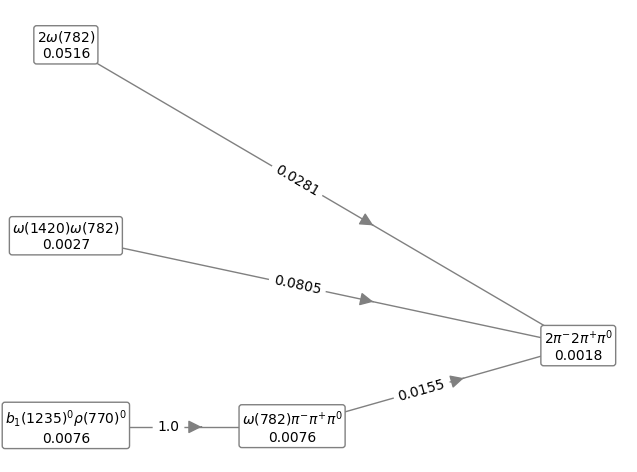

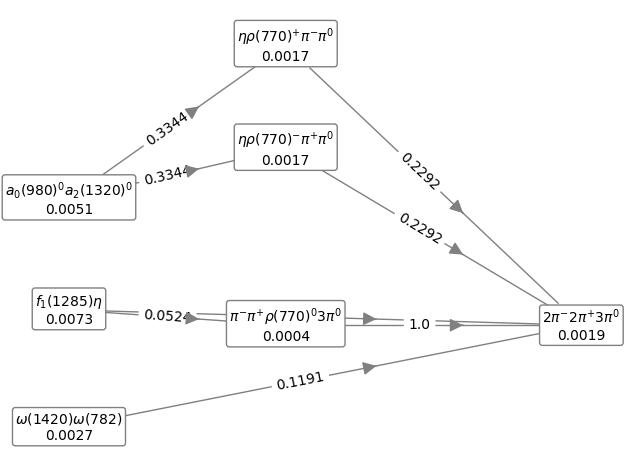

In [25]:
SH=ScalarHadronizer(2450,strange_weight=1.0215839592483356,spin_suppression=0.08655356535516996,gamma_fac=0.99998624832845)
SH.simulateDecay()
SH.plot_from_final_state((-211,-211,111,211,211))
SH.plot_from_final_state((-211,-211,111,111,111,211,211))

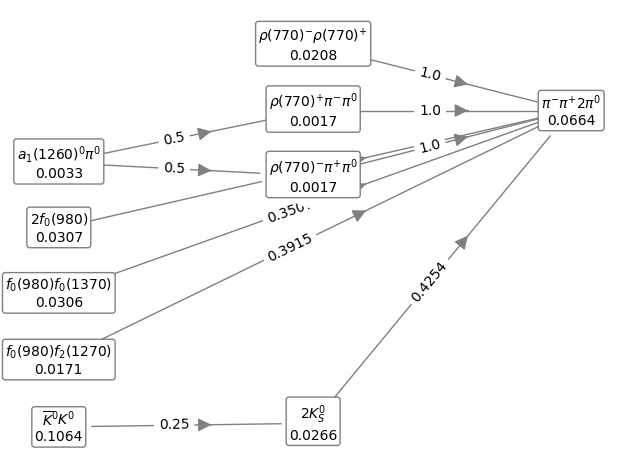

In [31]:
SH.plot_from_final_state((-211,111,111,211))

In [26]:
p.findall('rho')

[<Particle: name="rho(770)0", pdgid=113, mass=775.26 ± 0.23 MeV>,
 <Particle: name="rho(3)(1690)0", pdgid=117, mass=1688.8 ± 2.1 MeV>,
 <Particle: name="rho(770)+", pdgid=213, mass=775.1 ± 0.3 MeV>,
 <Particle: name="rho(770)-", pdgid=-213, mass=775.1 ± 0.3 MeV>,
 <Particle: name="rho(3)(1690)+", pdgid=217, mass=1688.8 ± 2.1 MeV>,
 <Particle: name="rho(3)(1690)-", pdgid=-217, mass=1688.8 ± 2.1 MeV>,
 <Particle: name="rho(1700)0", pdgid=30113, mass=1720 ± 20 MeV>,
 <Particle: name="rho(1700)+", pdgid=30213, mass=1720 ± 20 MeV>,
 <Particle: name="rho(1700)-", pdgid=-30213, mass=1720 ± 20 MeV>,
 <Particle: name="rho(1450)0", pdgid=100113, mass=1465 ± 25 MeV>,
 <Particle: name="rho(1450)+", pdgid=100213, mass=1465 ± 25 MeV>,
 <Particle: name="rho(1450)-", pdgid=-100213, mass=1465 ± 25 MeV>]

In [29]:
SH.single_particle_decays(221)

{(22, 22): 0.3961902842168918,
 (111, 111, 111): 0.3282604313646442,
 (-211, 211, 111): 0.22918766377746422,
 (22, -211, 211): 0.0463616206409998}